## Hands on session 5

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
from scipy.stats import linregress
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from datetime import datetime 
from pathlib import Path
import random
from matplotlib import colormaps
from astropy.table import Table
from astropy.io import fits 
DEBUG= False
THISDIR=os.getcwd()
#the photometric stuff is a magnitude (r_mag non serve qui)

#print(f"{THISDIR}\\Env_colors\\SDSS_EnvCatalogue.fits")
SDSS= Table.read(f"{THISDIR}\\Env_colors\\SDSS_EnvCatalogue.fits")
SDSS

<Table length=19344>
       OBJID             Ra        Dec     ...     zp        zp_err   
       int64          float64    float64   ...  float32     float32   
------------------- ----------- ---------- ... ---------- ------------
1237657776084419331 146.6266327 46.5347366 ...  16.038082  0.057954293
1237657776615718955 131.9390564 39.5363464 ...  13.622497  0.009696771
1237657776616505540 133.6787872 40.7019768 ...  15.719749  0.018026493
1237657776616833062 134.5747375 41.1183052 ...  16.429703  0.022935499
1237655469134119405 224.5936432  2.1276345 ...  17.682642   0.35379976
1237655469134184633   224.72612  1.9909116 ...  16.550394   0.04698791
1237655469134446881 225.3986053  1.9477262 ... 15.5573225  0.014990643
1237655470210613310 230.9415436  2.6702745 ...  15.479735  0.022180378
1237657117874520278 130.9886169 39.6054115 ...  14.573894  0.012608247
                ...         ...        ... ...        ...          ...
1237655465392734458 237.6950684 50.1182289 ...   16.49481    0.0793208
1237655465393717498 239.8766479 48.4747734 ...  16.931648   0.05303345
1237657775542763935 134.4645844 39.9770889 ...  17.267227   0.12510142
1237657775543681134 136.7258148 41.3196869 ...  15.626291  0.026293645
1237655468062146662 228.6832275  1.1542898 ...  12.289923 0.0041065575
1237651752395604120   170.65271  1.3101189 ...  16.303822   0.07236582
1237651752396194136 171.9872742  1.2994713 ...  16.955017   0.13314827
1237651752399864040 180.3818512  1.2958331 ...  15.902146   0.06321485
1237651752402223198 185.6894836    1.27442 ...   15.93333   0.07963987
1237651752402288792 185.9304199   1.311089 ...  16.790886    0.0775715

### Plot the distribution of galaxies on the sky. 

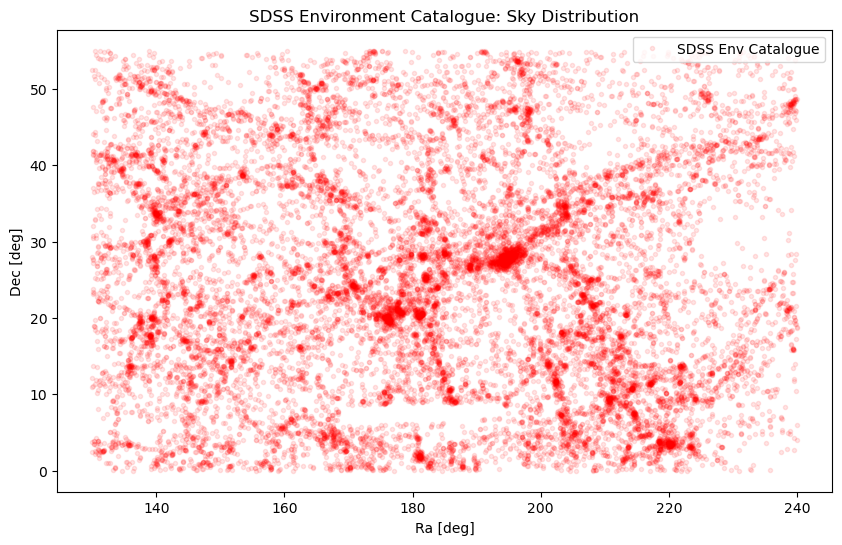

In [3]:
plt.figure(figsize=(10,6))
plt.plot(SDSS['Ra'],SDSS['Dec'],'.', alpha=0.1, label='SDSS Env Catalogue', color='red')
plt.legend()
plt.ylabel('Dec [deg]')
plt.xlabel('Ra [deg]')
plt.title('SDSS Environment Catalogue: Sky Distribution')
plt.show()

Survey Area: 1.5720 sr
Survey Volume: 9.74e+05 Mpc^3
Mean Galaxy Density: 5.67e-01 galaxies/Mpc^2


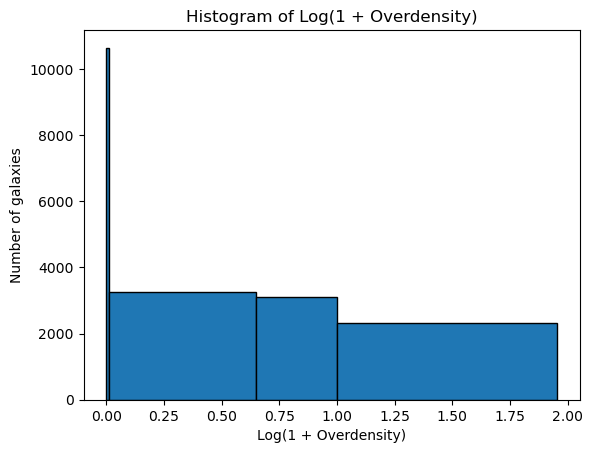

In [4]:
#volume of the survey
ra = SDSS['Ra']
dec = SDSS['Dec']
max_ra = np.max(ra)
min_ra = np.min(ra)
max_dec = np.max(dec)
min_dec = np.min(dec) #solid angle formula
area_sr = (np.sin(np.radians(max_dec)) - np.sin(np.radians(min_dec))) * np.radians(max_ra - min_ra)
area_deg2 = area_sr * (180/np.pi)**2
print(f"Survey Area: {area_sr:.4f} sr")
z=SDSS['redshift']
H0=70 #km/s/Mpc
distance=(3e5 * z)/H0 #Mpc
volume_Mpc3 = area_sr/3 * (np.max(distance)**3-np.min(distance)**3)    #survey volume in Mpc^3
print(f"Survey Volume: {volume_Mpc3:.2e} Mpc^3")
Mean_density = len(SDSS)/volume_Mpc3*(2000/H0) #2000/H0 is the depth in Mpc of the cylinder
print(f"Mean Galaxy Density: {Mean_density:.2e} galaxies/Mpc^2")
D3_density = SDSS['dens_05'] #volume density in galaxies/Mpc^2
overdensity = D3_density / Mean_density
log_odensity = np.log10(1+overdensity)
if DEBUG:
    for elem in log_odensity:
        print(f"{elem:.4f}")
ip = SDSS['ip']
ip_err = SDSS['ip_err']
gp = SDSS['gp']
gp_err = SDSS['gp_err']
Diff_gi= gp - ip
Diff_gi_err= np.sqrt(gp_err**2 + ip_err**2)
#now we need to bin the data in overdensity bins and then plot the color-mass diagram
bin_edges = [0, 0.01, 0.65, 1, max(log_odensity)+0.01]
plt.hist(log_odensity, bins=bin_edges, edgecolor='black') #binning of the overdensity 
plt.xlabel('Log(1 + Overdensity)')
plt.ylabel('Number of galaxies')
plt.title('Histogram of Log(1 + Overdensity)')
plt.show()

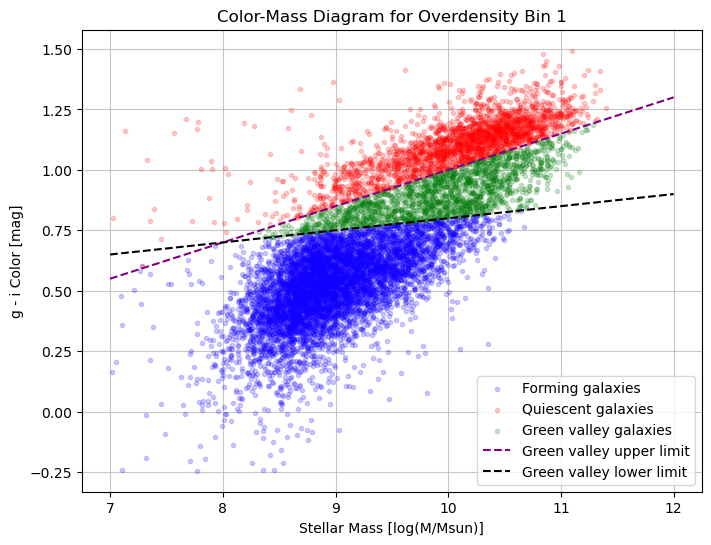

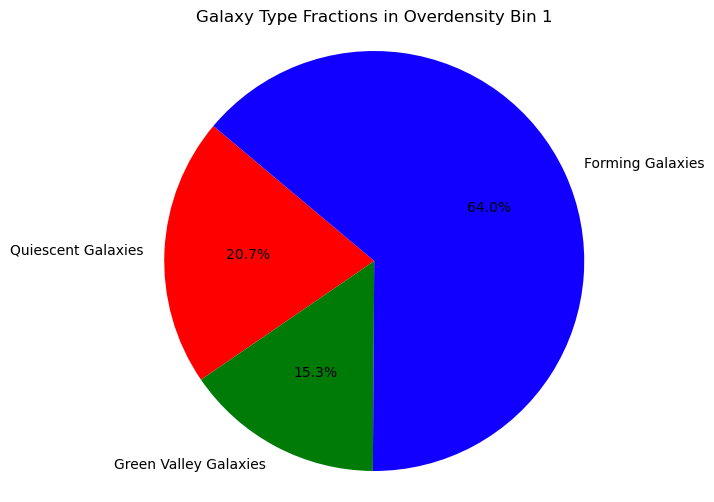

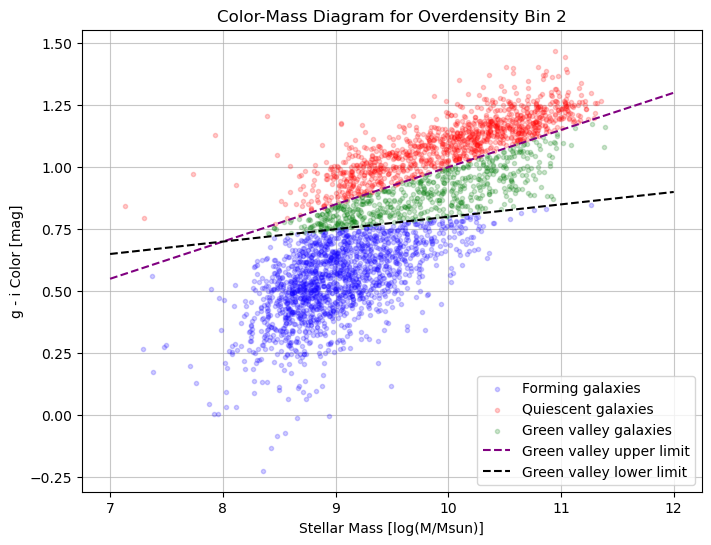

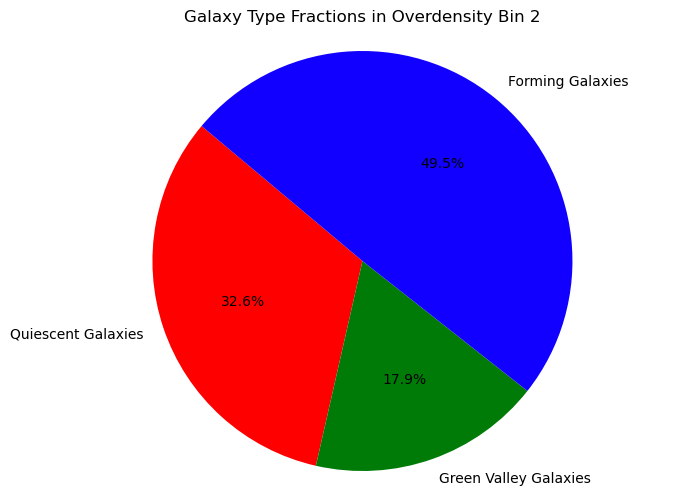

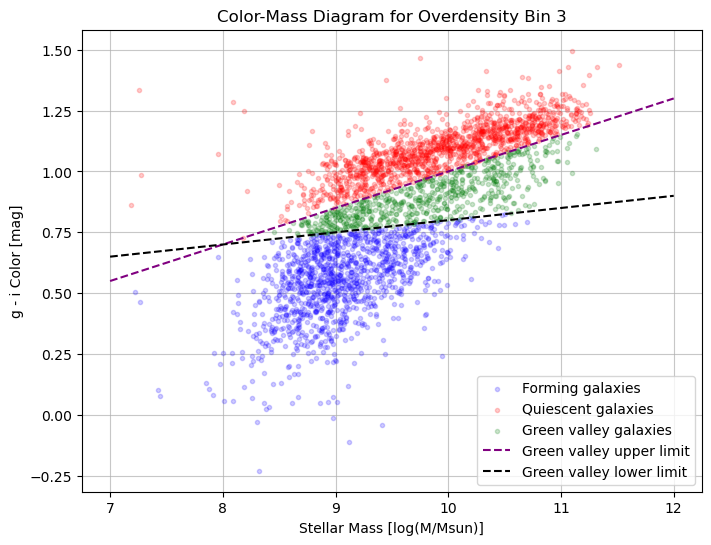

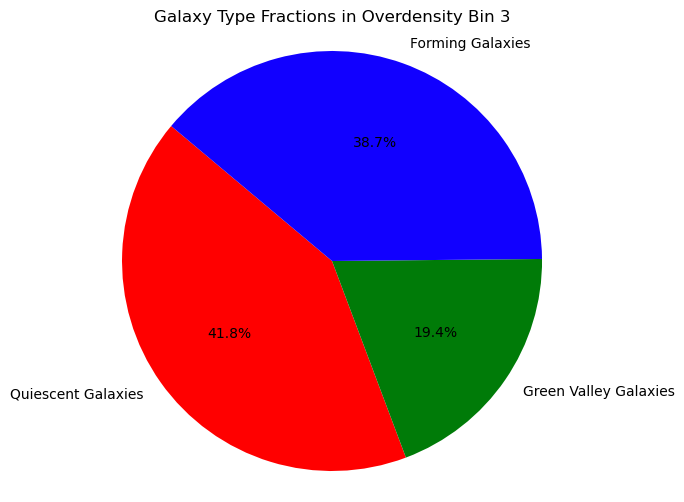

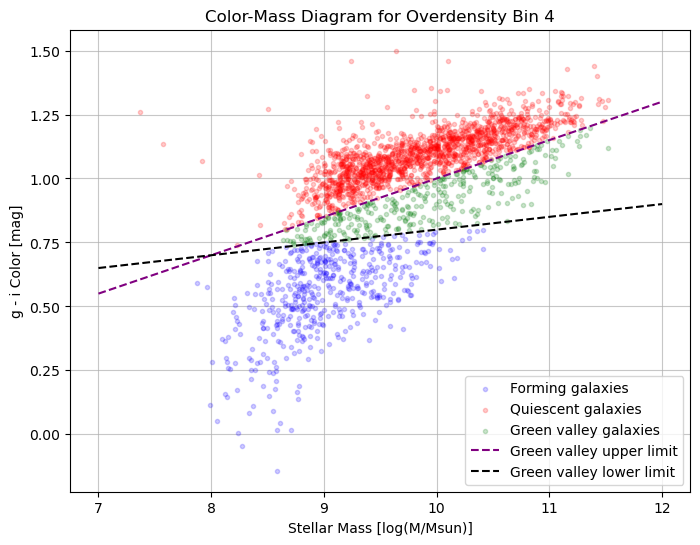

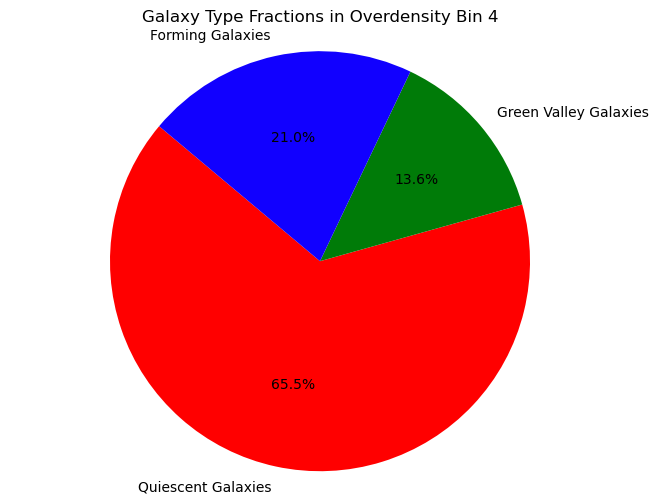

In [5]:
def linearfunc (x, m, q):
    return m*x+q

fakex=np.linspace(7,12,1000)
fakey1=linearfunc(fakex,0.15,-0.5)
fakey2=linearfunc(fakex,0.05,0.3)
red_fraction = []
green_fraction = []
blue_fraction = []

for i in range(len(bin_edges)-1):
    bin_mask = (log_odensity >= bin_edges[i]) & (log_odensity < bin_edges[i+1]) & (SDSS['mass'] > 7) & (SDSS['mass'] < 12) & (Diff_gi > -0.25) & (Diff_gi < 1.5) #mask for the current overdensity bin, cutting the non necessary mass and color ranges
    forming_mask = bin_mask & (Diff_gi < (0.05 * SDSS['mass'] + 0.3)) #under the lower green valley limit
    quiescent_mask = bin_mask & (Diff_gi > (0.15 * SDSS['mass'] - 0.5)) #above the upper green valley limit
    green_mask = bin_mask & ( (Diff_gi >= (0.05 * SDSS['mass'] + 0.3)) & (Diff_gi <= (0.15 * SDSS['mass'] - 0.5)) ) #in between the two limits
    plt.figure(figsize=(8,6))
    plt.scatter(SDSS['mass'][forming_mask], Diff_gi[forming_mask], marker='.', alpha=0.2, label=f'Forming galaxies', color="#1100FF", zorder=10)
    plt.scatter(SDSS['mass'][quiescent_mask], Diff_gi[quiescent_mask], marker='.', alpha=0.2, label=f'Quiescent galaxies', color="#FF0000", zorder=10)
    plt.scatter(SDSS['mass'][green_mask], Diff_gi[green_mask], marker='.', alpha=0.2, label=f'Green valley galaxies', color="#007B08", zorder=10)
    plt.plot(fakex, fakey1, label='Green valley upper limit', color='purple', linestyle='--', zorder=20)
    plt.plot(fakex, fakey2, label='Green valley lower limit', color='black', linestyle='--', zorder=20)
    plt.xlabel('Stellar Mass [log(M/Msun)]')
    plt.ylabel('g - i Color [mag]') 
    plt.legend()
    plt.grid(alpha=0.7, zorder=0)
    plt.title(f'Color-Mass Diagram for Overdensity Bin {i+1}')
    plt.show()

    plt.figure(figsize=(8,6)) #pie chart for the fractions
    sizes = [len(Diff_gi[quiescent_mask]), len(Diff_gi[green_mask]), len(Diff_gi[forming_mask])]
    labels = ['Quiescent Galaxies', 'Green Valley Galaxies', 'Forming Galaxies']
    colors = ['#FF0000', '#007B08', '#1100FF']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'Galaxy Type Fractions in Overdensity Bin {i+1}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    red_fraction.append(len(Diff_gi[quiescent_mask]) / len(Diff_gi[bin_mask]))
    #print(f"Red Fraction in Overdensity Bin ({bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}): {red_fraction:.4f}")



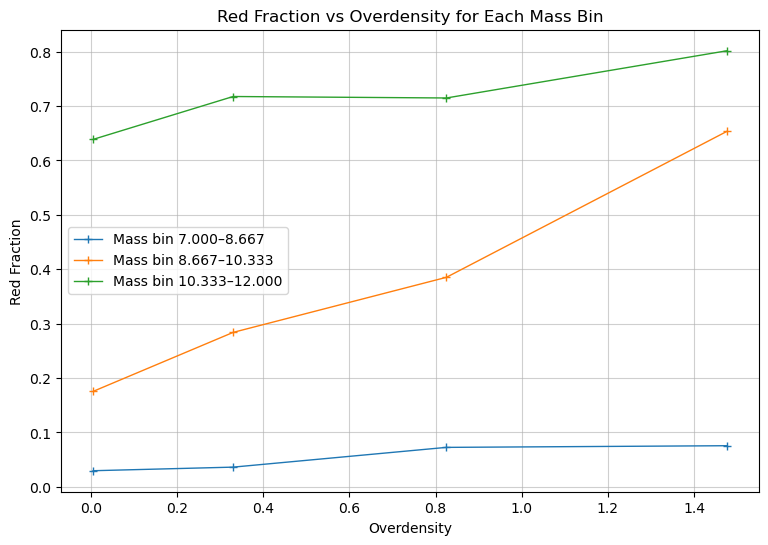

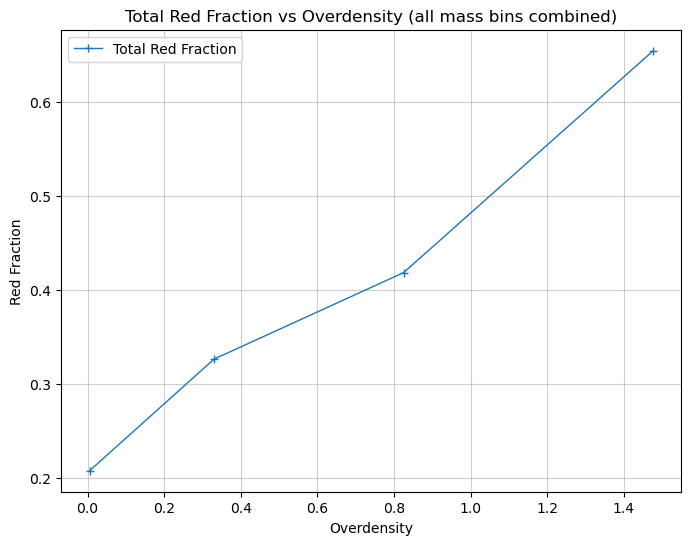

In [6]:
# mass bins (sta parte la ha chiesta Fossati )
mass_bins = np.linspace(7, 12, 4)  # 4 bins from 7 to 12
mass_bin_centers = [(mass_bins[i] + mass_bins[i+1]) / 2 for i in range(len(mass_bins)-1)]


# red_fraction_mass_bin[mass_bin][overdensity_bin]
red_fraction_mass_bin = [[0 for _ in range(len(bin_edges)-1)] for _ in range(len(mass_bins)-1)]
 
for i in range(len(bin_edges)-1):  # bin overdensity
    overd_mask = (log_odensity >= bin_edges[i]) & (log_odensity < bin_edges[i+1])

    for j in range(len(mass_bins)-1):  # bin mass
        mass_mask = (SDSS['mass'] >= mass_bins[j]) & (SDSS['mass'] < mass_bins[j+1])

        bin_mask = overd_mask & mass_mask & (Diff_gi > -0.25) & (Diff_gi < 1.5)
        quiescent_mask = bin_mask & (Diff_gi > (0.15 * SDSS['mass'] - 0.5))

        if len(SDSS[bin_mask]) > 0:
            red_fraction_mass_bin[j][i] = len(SDSS[quiescent_mask]) / len(SDSS[bin_mask])
        else:
            red_fraction_mass_bin[j][i] = np.nan  

plt.figure(figsize=(9,6))
overdensity_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
for j in range(len(mass_bins)-1):
    plt.plot(overdensity_centers, red_fraction_mass_bin[j],
             marker='+', linewidth=1,
             label=f"Mass bin {mass_bins[j]:.3f}–{mass_bins[j+1]:.3f}")
plt.xlabel("Overdensity")
plt.ylabel("Red Fraction")
plt.title("Red Fraction vs Overdensity for Each Mass Bin")
plt.grid(alpha=0.6)
plt.legend()
plt.show()


red_fraction_total = []

for i in range(len(bin_edges)-1):
    overd_mask = (log_odensity >= bin_edges[i]) & (log_odensity < bin_edges[i+1])
    bin_mask = overd_mask & (Diff_gi > -0.25) & (Diff_gi < 1.5)

    quiescent_mask = bin_mask & (Diff_gi > (0.15 * SDSS['mass'] - 0.5))

    if np.sum(bin_mask) > 0:
        rf = np.sum(quiescent_mask) / np.sum(bin_mask)
    else:
        rf = np.nan

    red_fraction_total.append(rf)

plt.figure(figsize=(8,6))

plt.plot(overdensity_centers, red_fraction_total,
         marker='+', linewidth=1, label="Total Red Fraction")
plt.xlabel("Overdensity")
plt.ylabel("Red Fraction")
plt.title("Total Red Fraction vs Overdensity (all mass bins combined)")
plt.grid(alpha=0.6)
plt.legend()
plt.show()


In [16]:
def chi_squared_asymmetric(residuals, err): 
    chi2 = np.sum((residuals / err)**2)/len(residuals)
    return chi2
#function to calculate the chi squared reduced

### Second part of the Hands on Session 5


>>> Processing region 1 ...


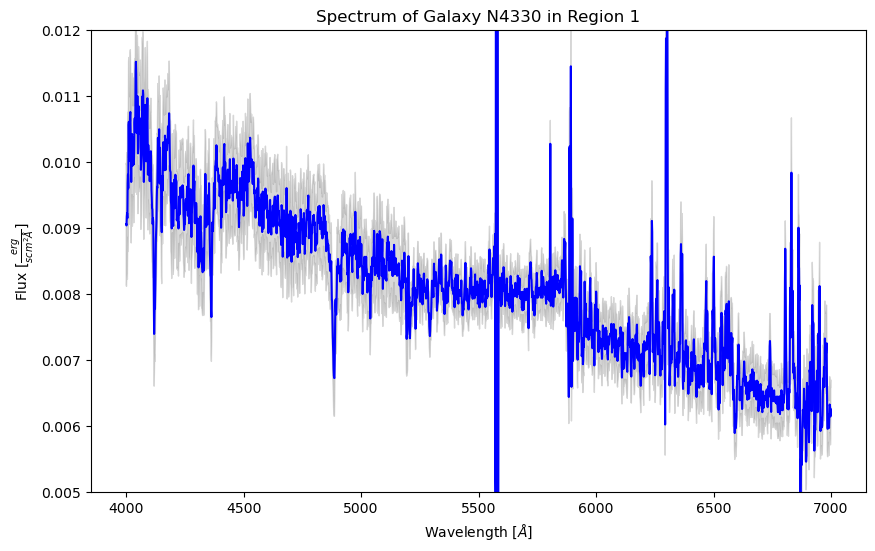

Regional photometry: 
  id f_FUV e_FUV  f_NUV e_NUV  f_U  ...  e_Z  f_IRAC1 e_IRAC1 f_IRAC4 e_IRAC4
--- ----- ------ ----- ----- ----- ... ----- ------- ------- ------- -------
  1  0.07 0.0025 0.111 0.005 0.513 ... 0.181   1.329    0.11   0.341   0.197
Minumin of the chi squared reduced: 0.0005159902154319144, at index: 63
Minumin of the chi squared photometric reduced: 0.05326932334639645, at index: 85


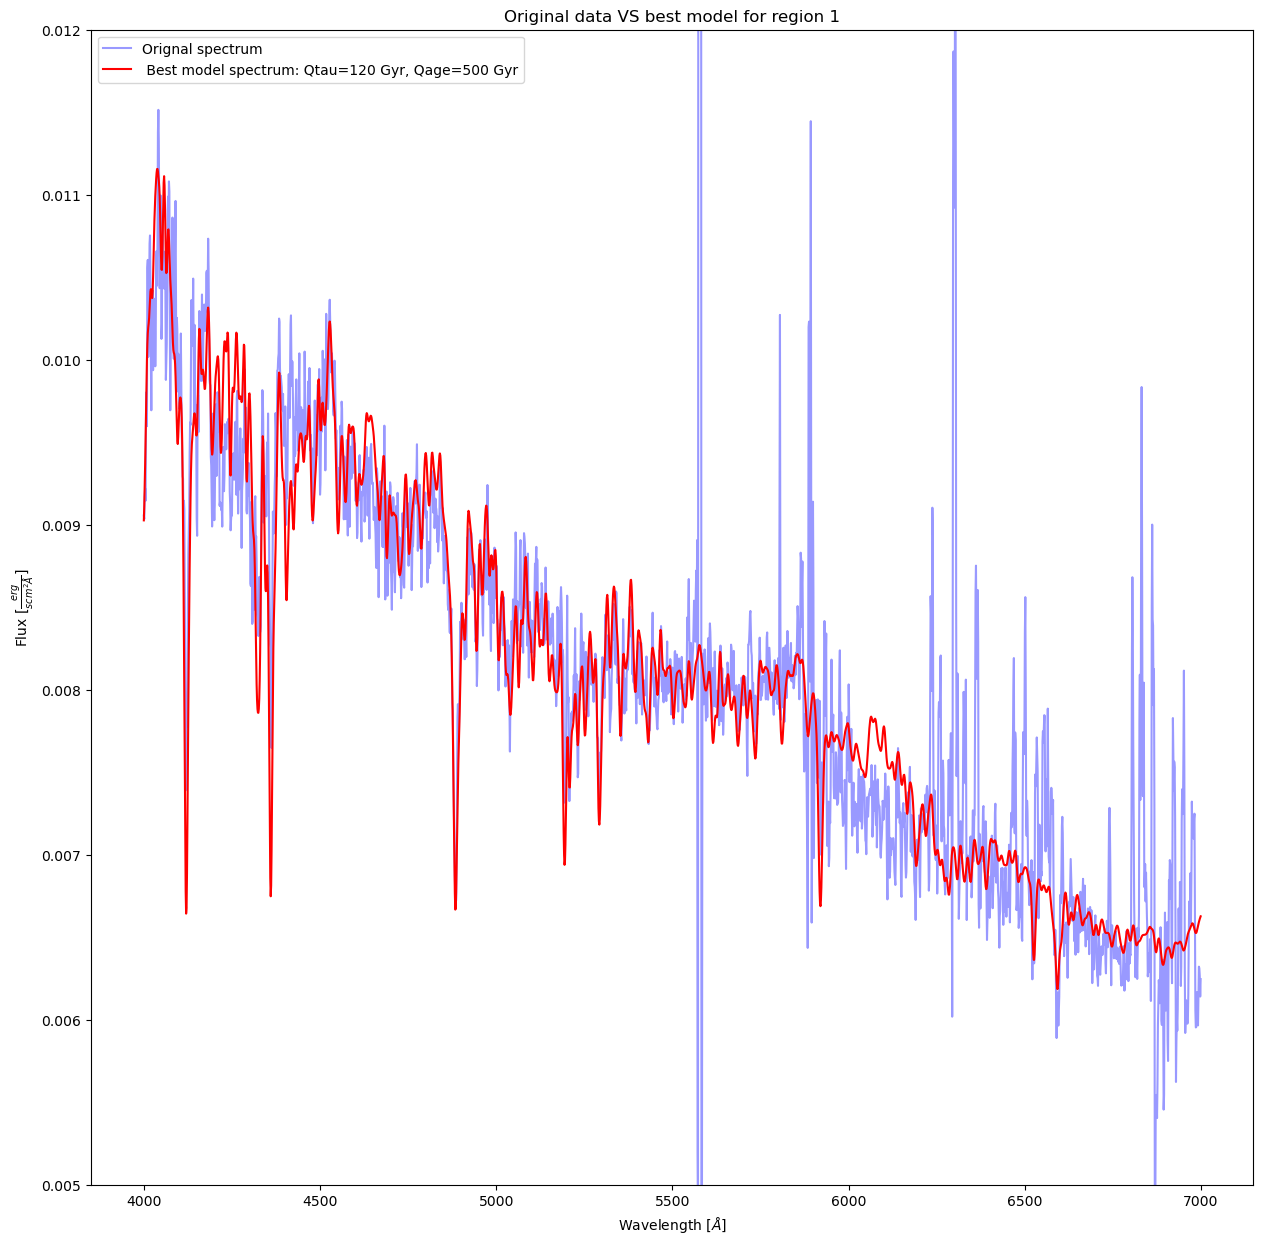

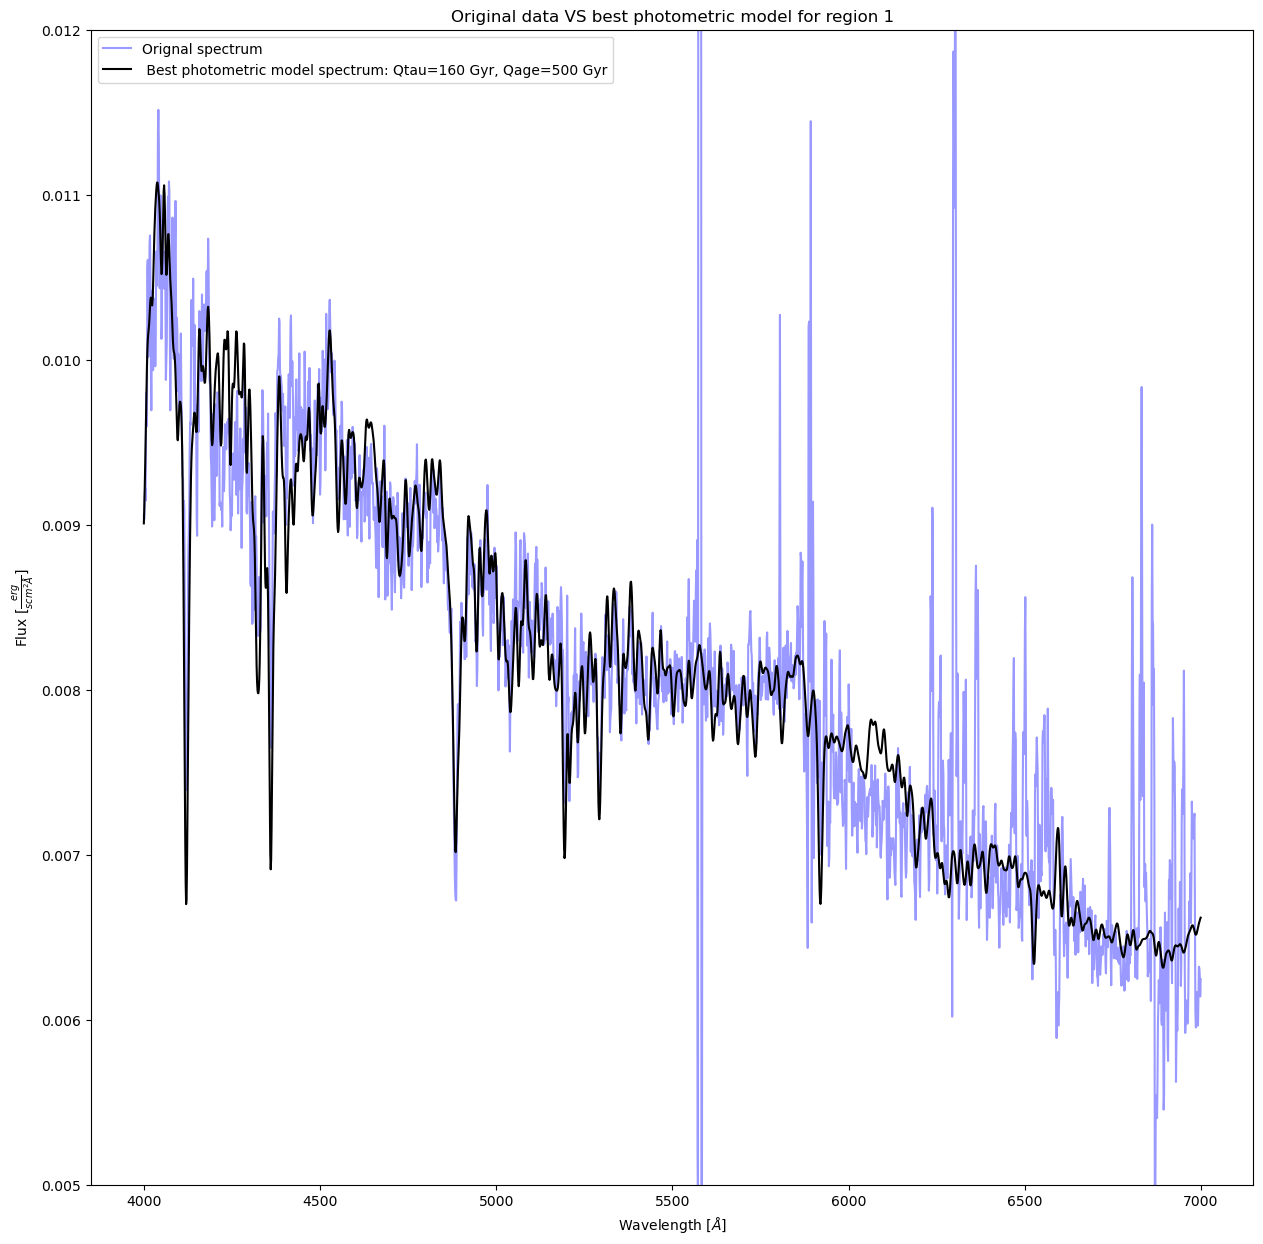

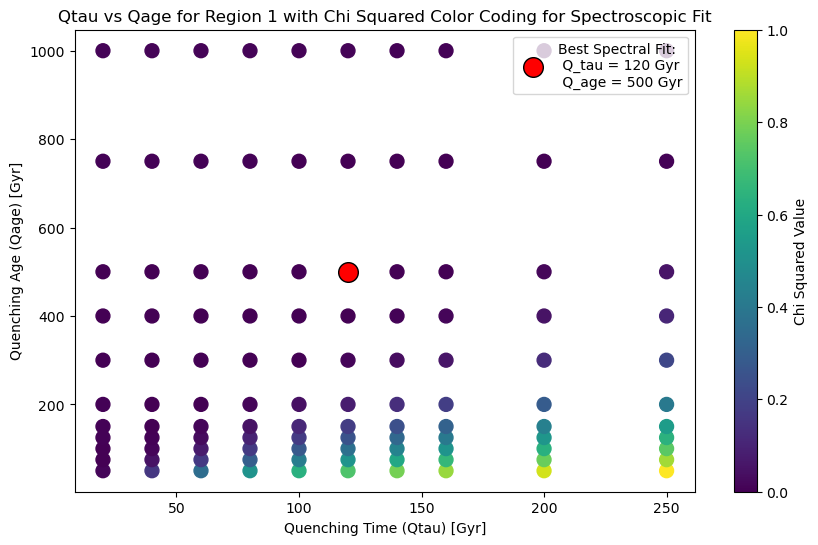

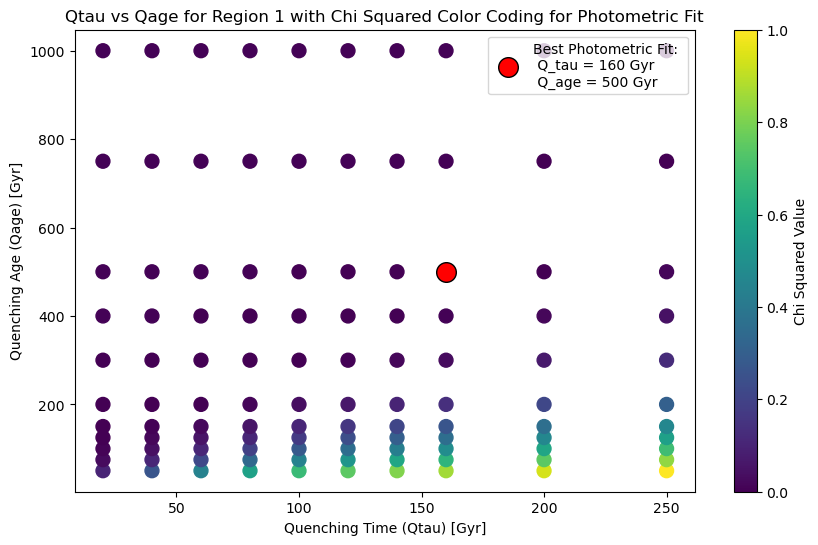


>>> Processing region 2 ...


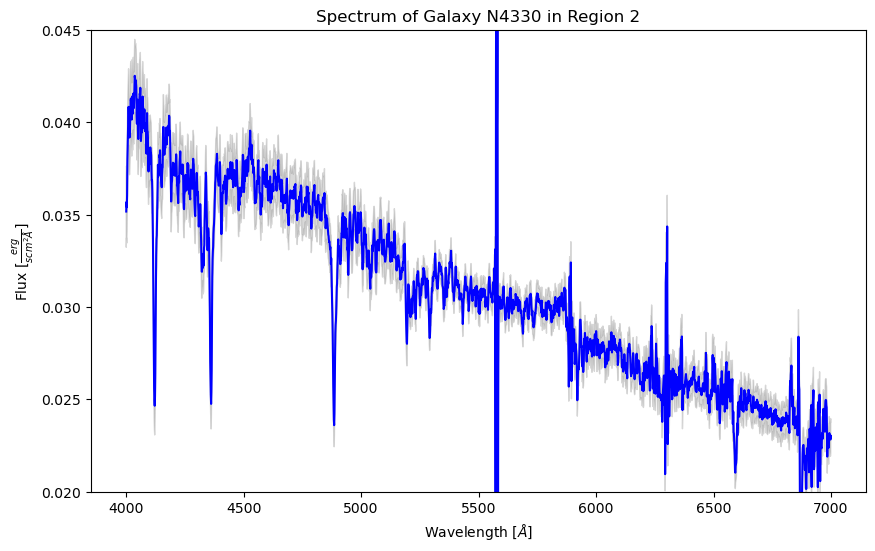

Regional photometry: 
  id f_FUV e_FUV f_NUV e_NUV  f_U  ...  f_Z  e_Z  f_IRAC1 e_IRAC1 f_IRAC4 e_IRAC4
--- ----- ----- ----- ----- ----- ... ----- ---- ------- ------- ------- -------
  2 0.107 0.005 0.171 0.008 0.686 ... 3.027 0.11   1.477   0.049   0.598    0.08
Minumin of the chi squared reduced: 0.0004013974211597698, at index: 2
Minumin of the chi squared photometric reduced: 0.1934835574486219, at index: 15


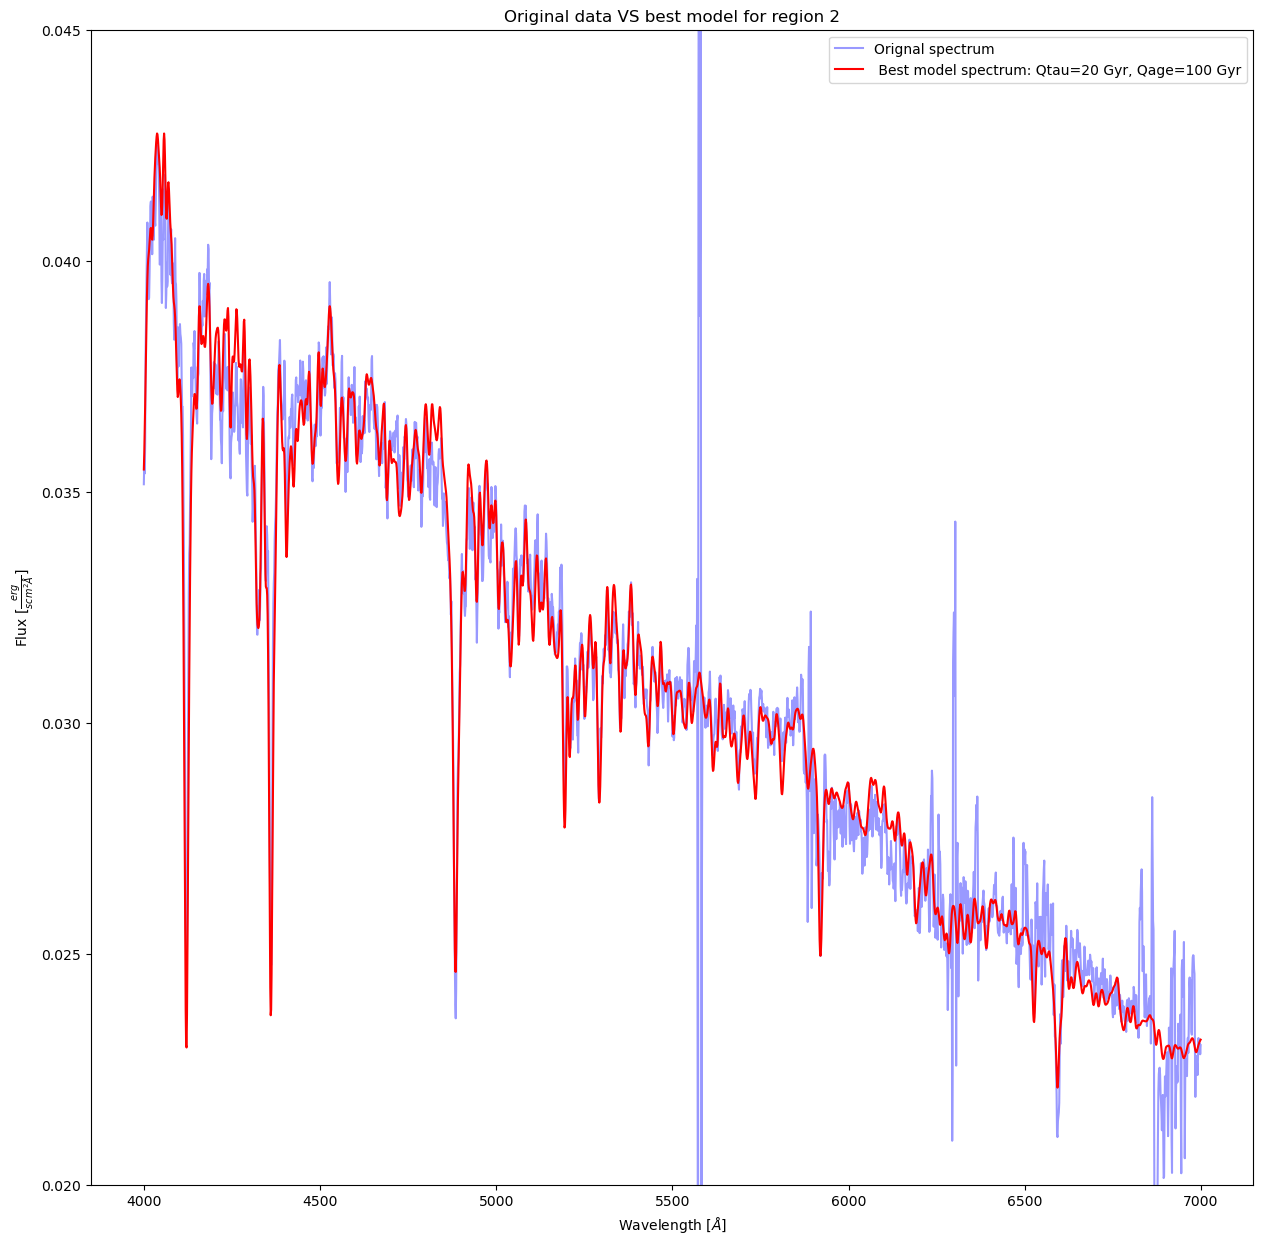

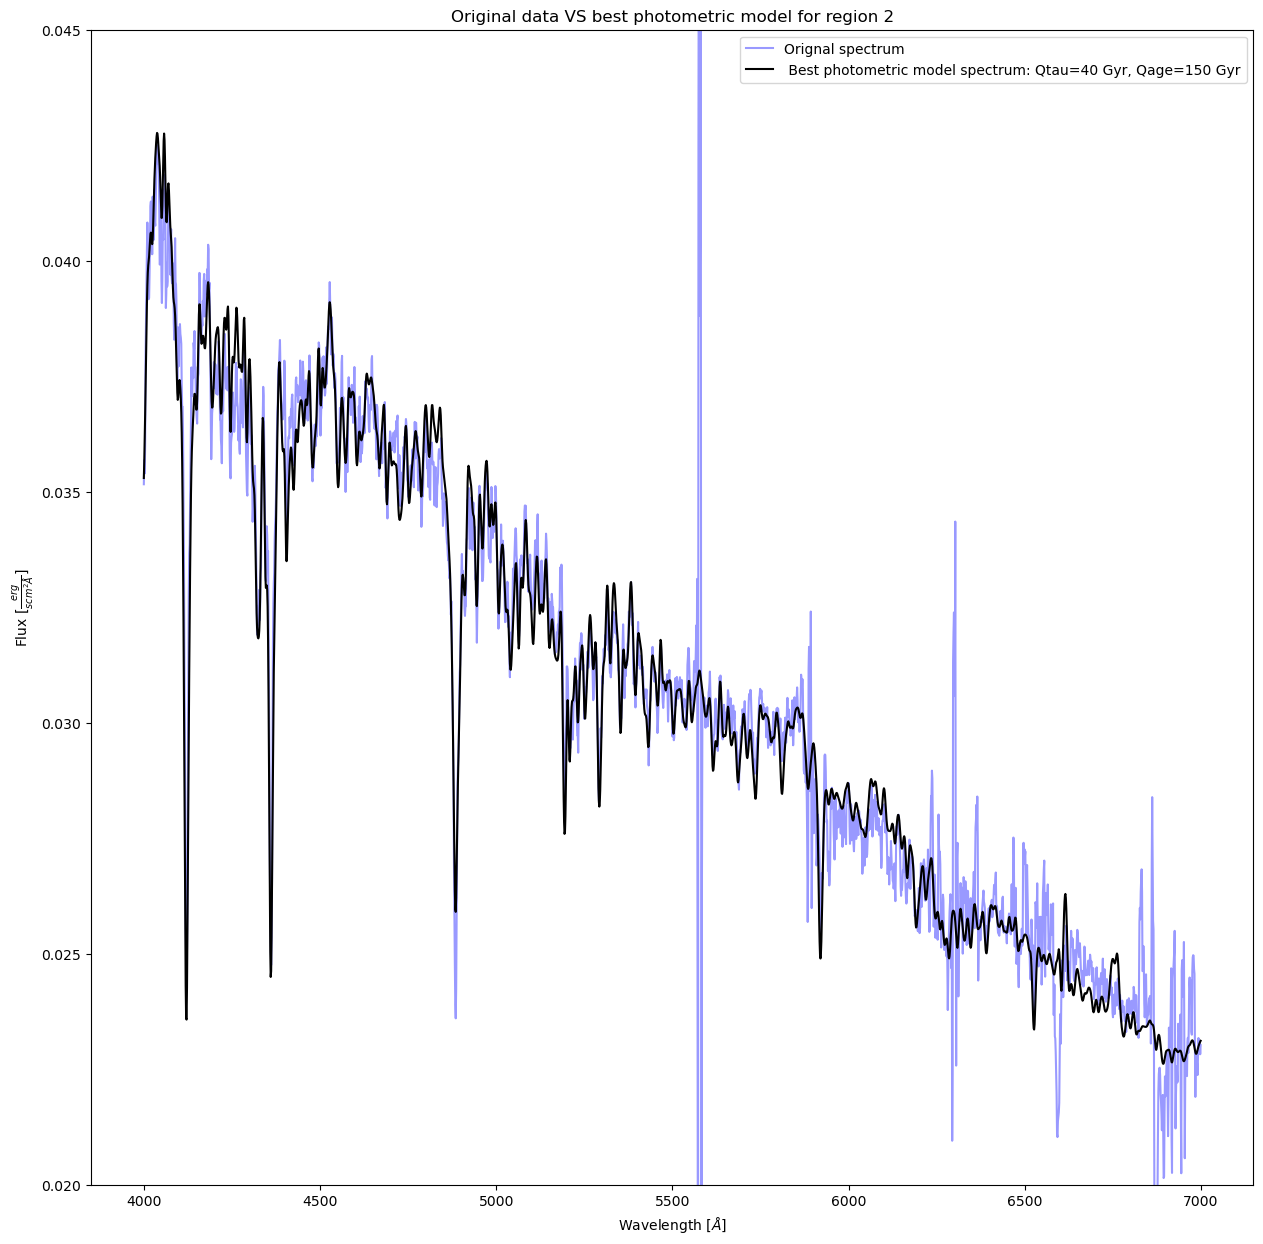

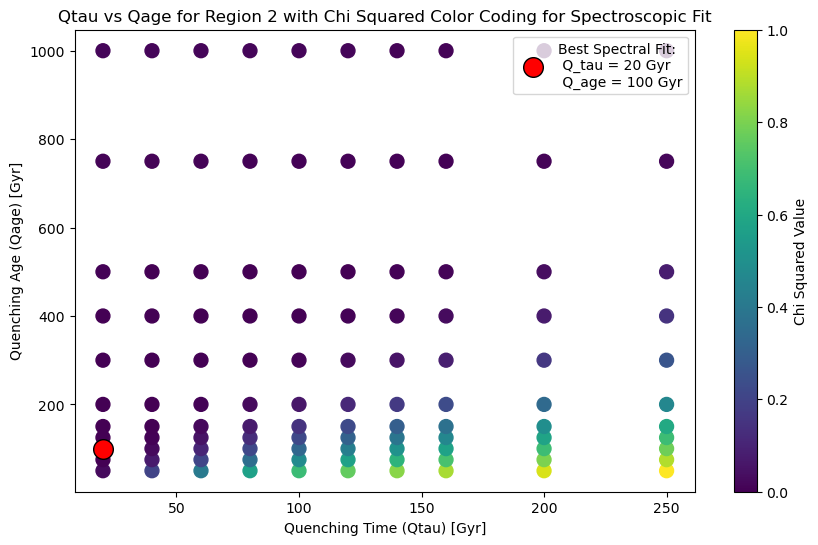

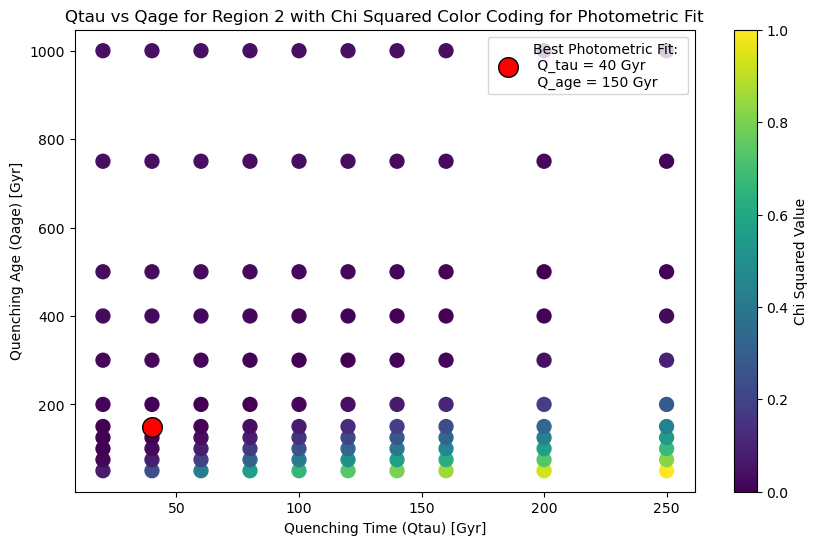


>>> Processing region 3 ...


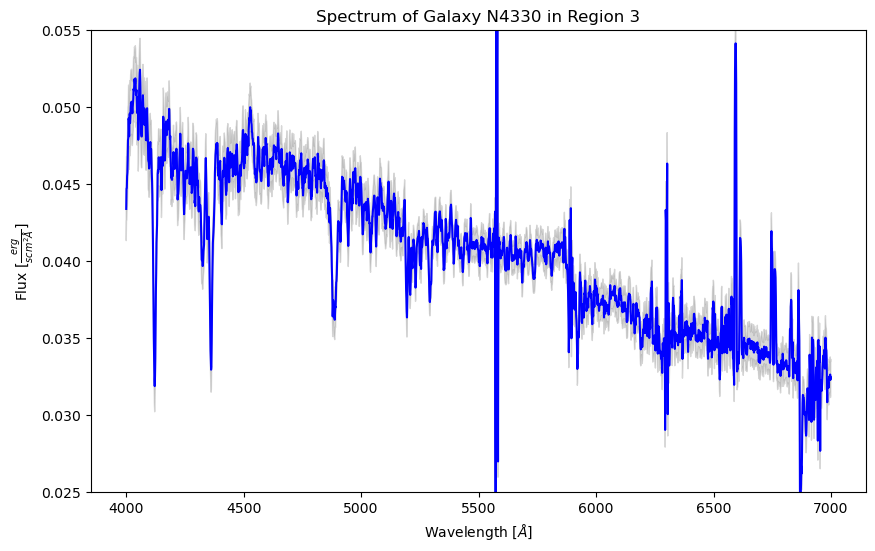

Regional photometry: 
  id f_FUV  e_FUV f_NUV e_NUV  f_U  ...  e_Z  f_IRAC1 e_IRAC1 f_IRAC4 e_IRAC4
--- ------ ----- ----- ----- ----- ... ----- ------- ------- ------- -------
  3 0.1229 0.006 0.188 0.009 0.845 ... 0.148   2.452   0.052   3.079   0.085
Minumin of the chi squared reduced: 0.0004577703232945154, at index: 27
Minumin of the chi squared photometric reduced: 0.08500313812466452, at index: 15


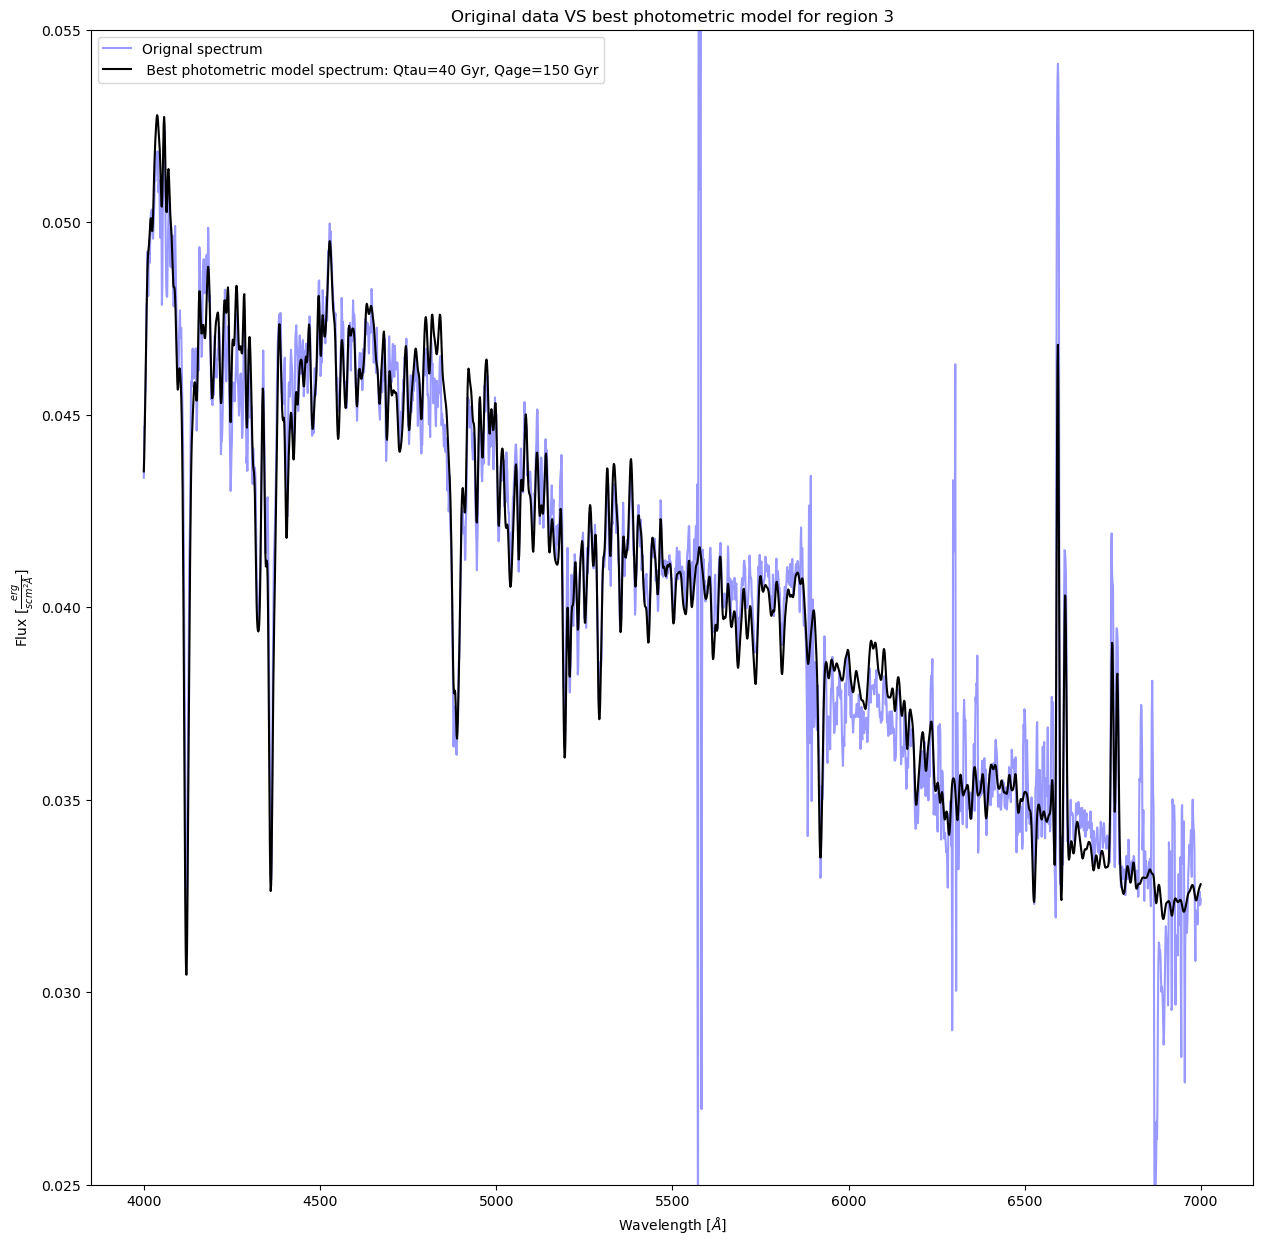

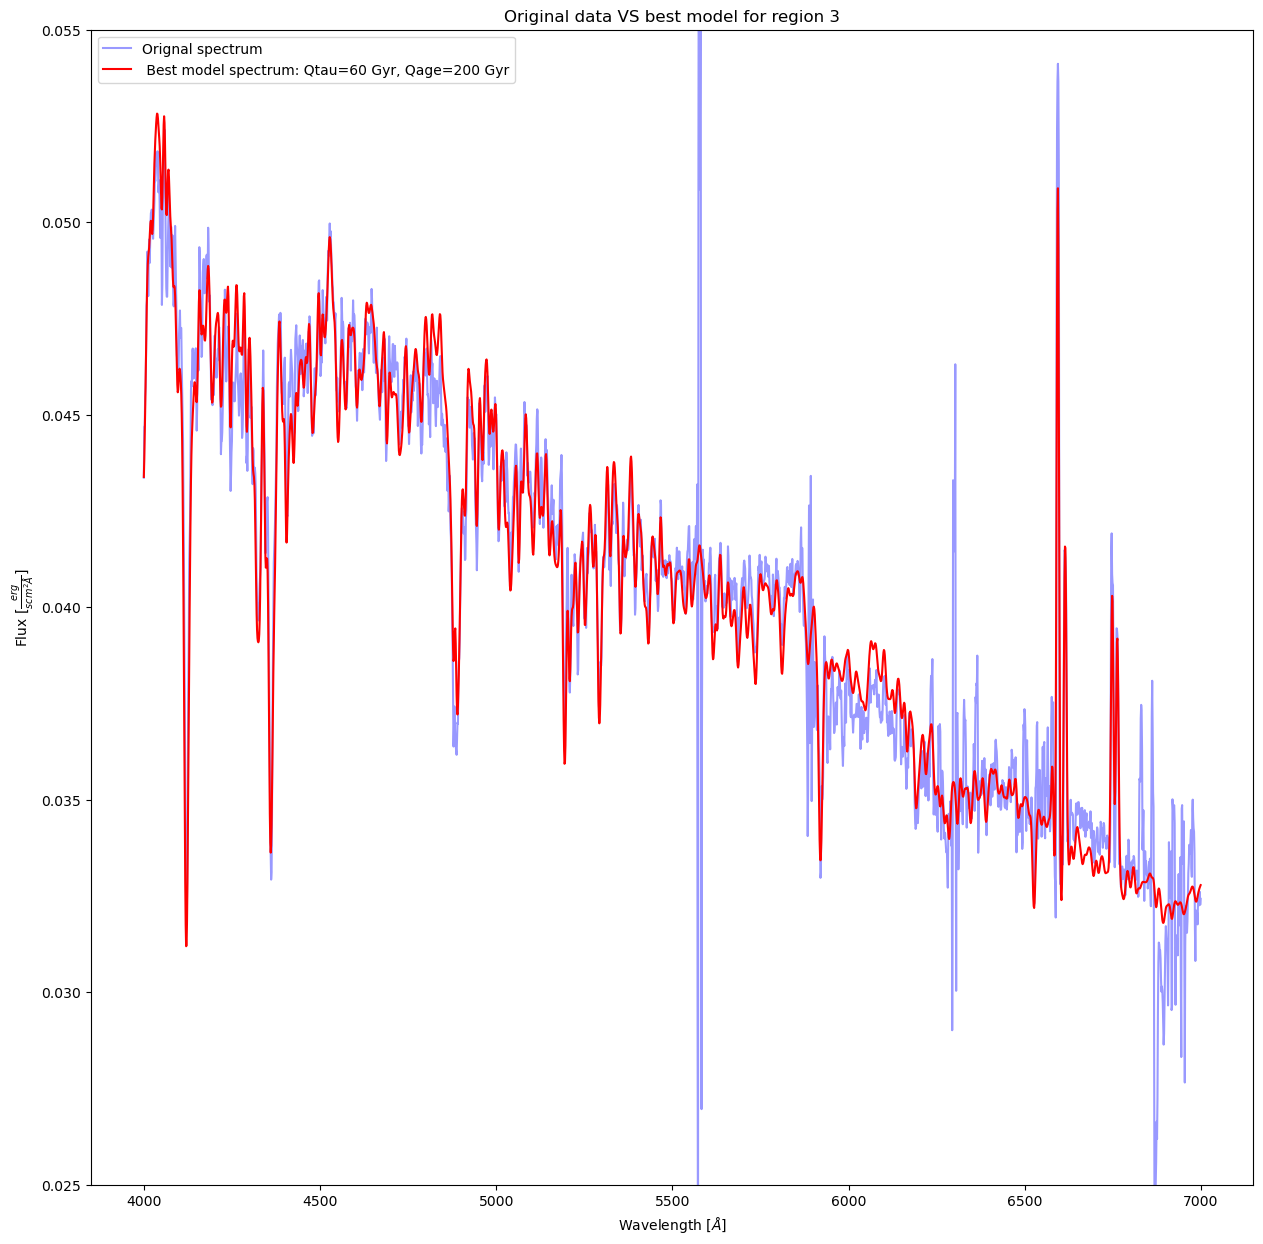

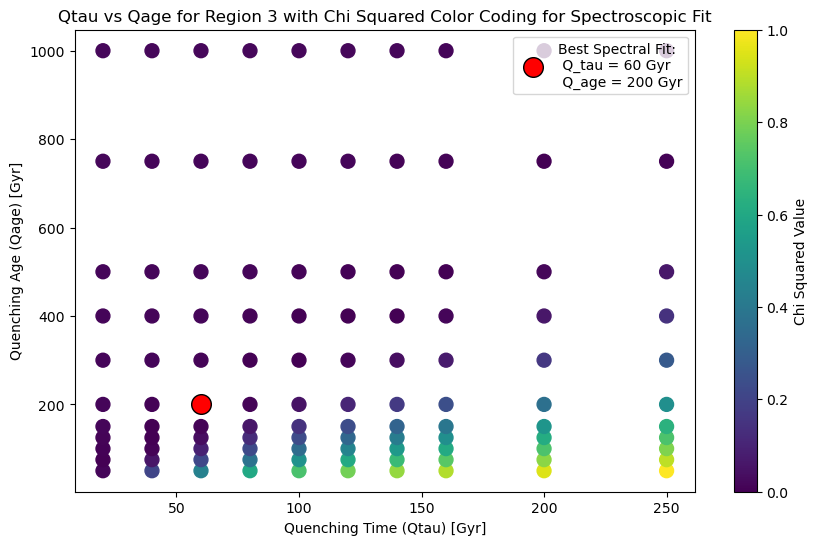

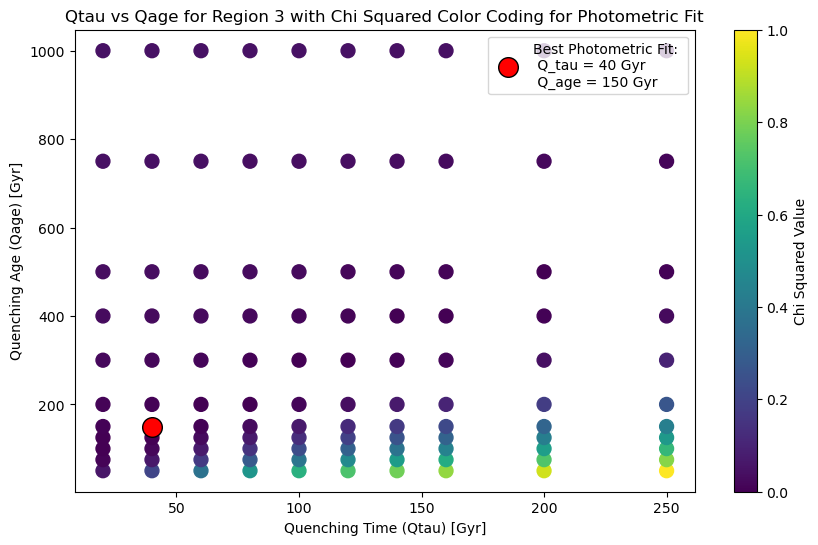


>>> Processing region 11 ...


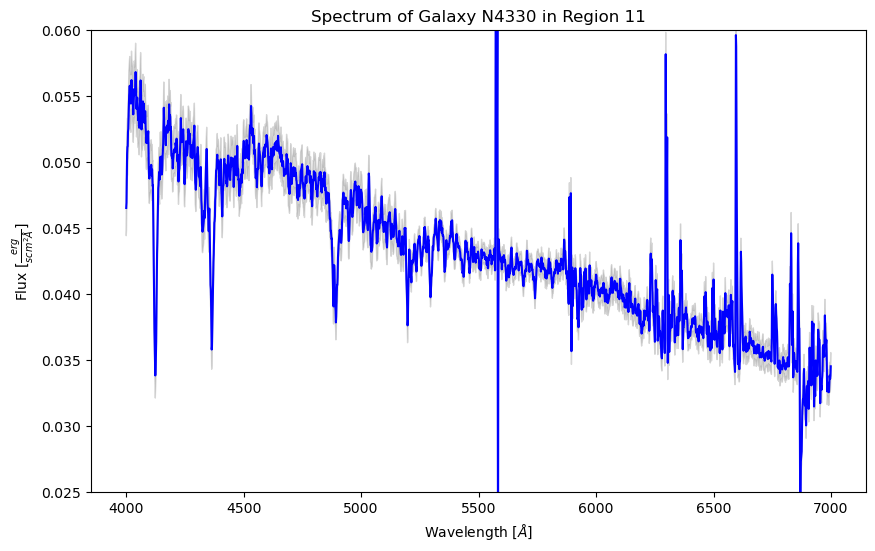

Regional photometry: 
  id f_FUV e_FUV f_NUV e_NUV  f_U  ...  e_Z  f_IRAC1 e_IRAC1 f_IRAC4 e_IRAC4
--- ----- ----- ----- ----- ----- ... ----- ------- ------- ------- -------
 11 0.145  0.07 0.219  0.01 0.848 ... 0.131   2.068   0.052   3.326   0.084
Minumin of the chi squared reduced: 0.0008823655497792658, at index: 1
Minumin of the chi squared photometric reduced: 0.17539978754183325, at index: 1


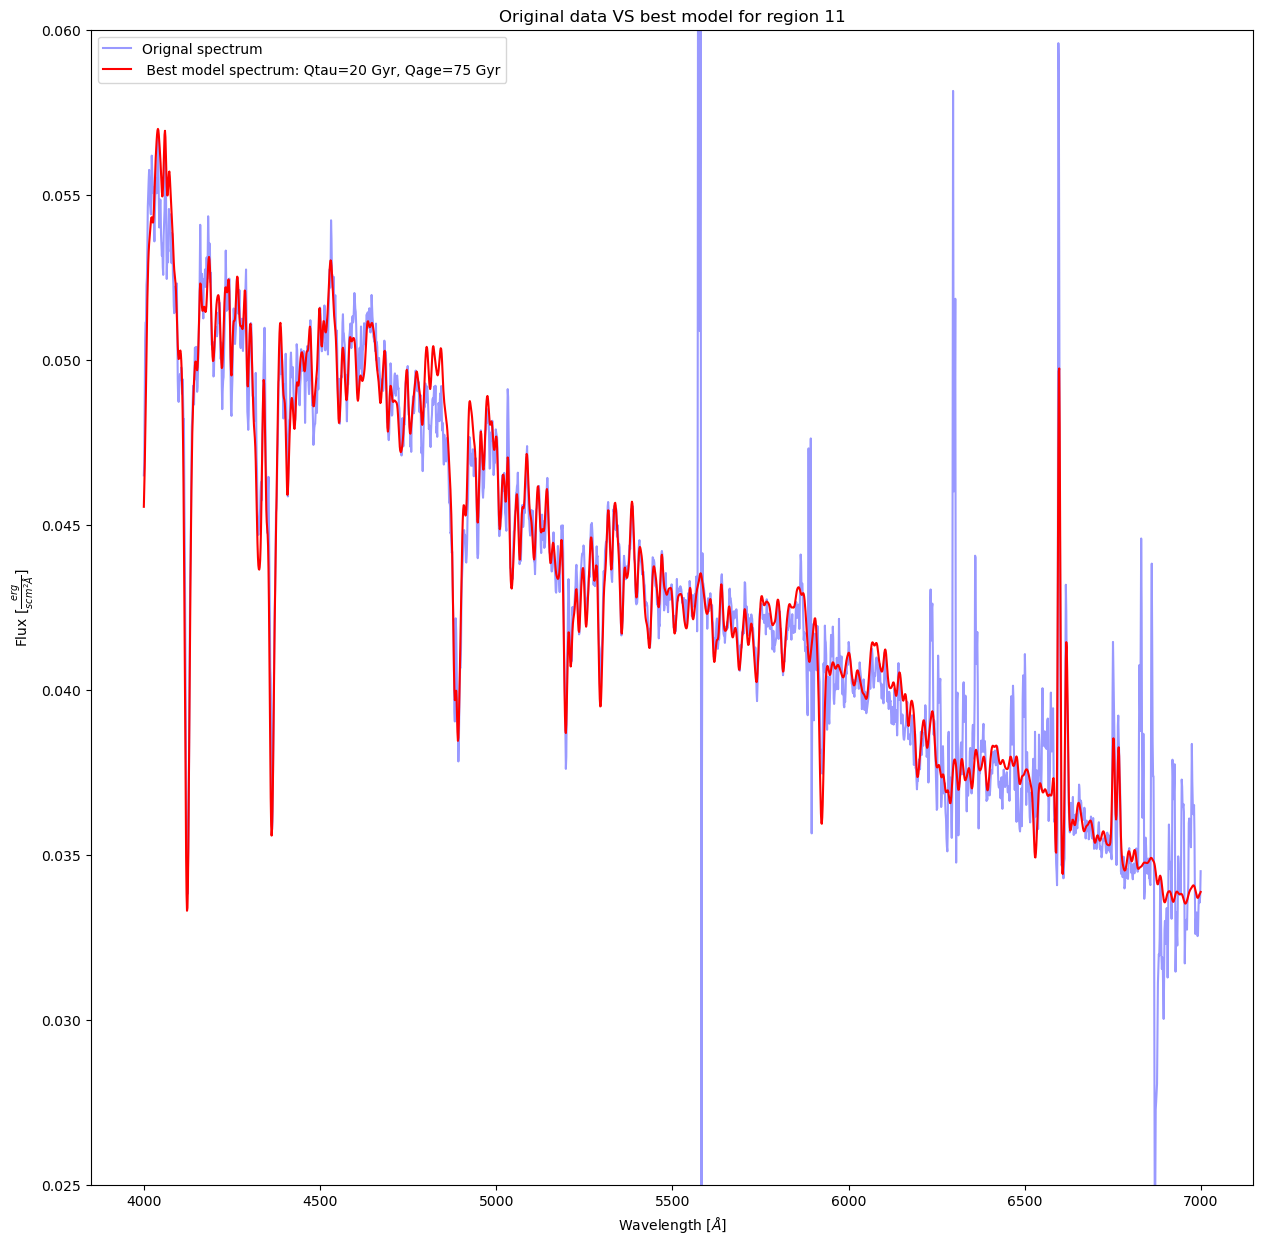

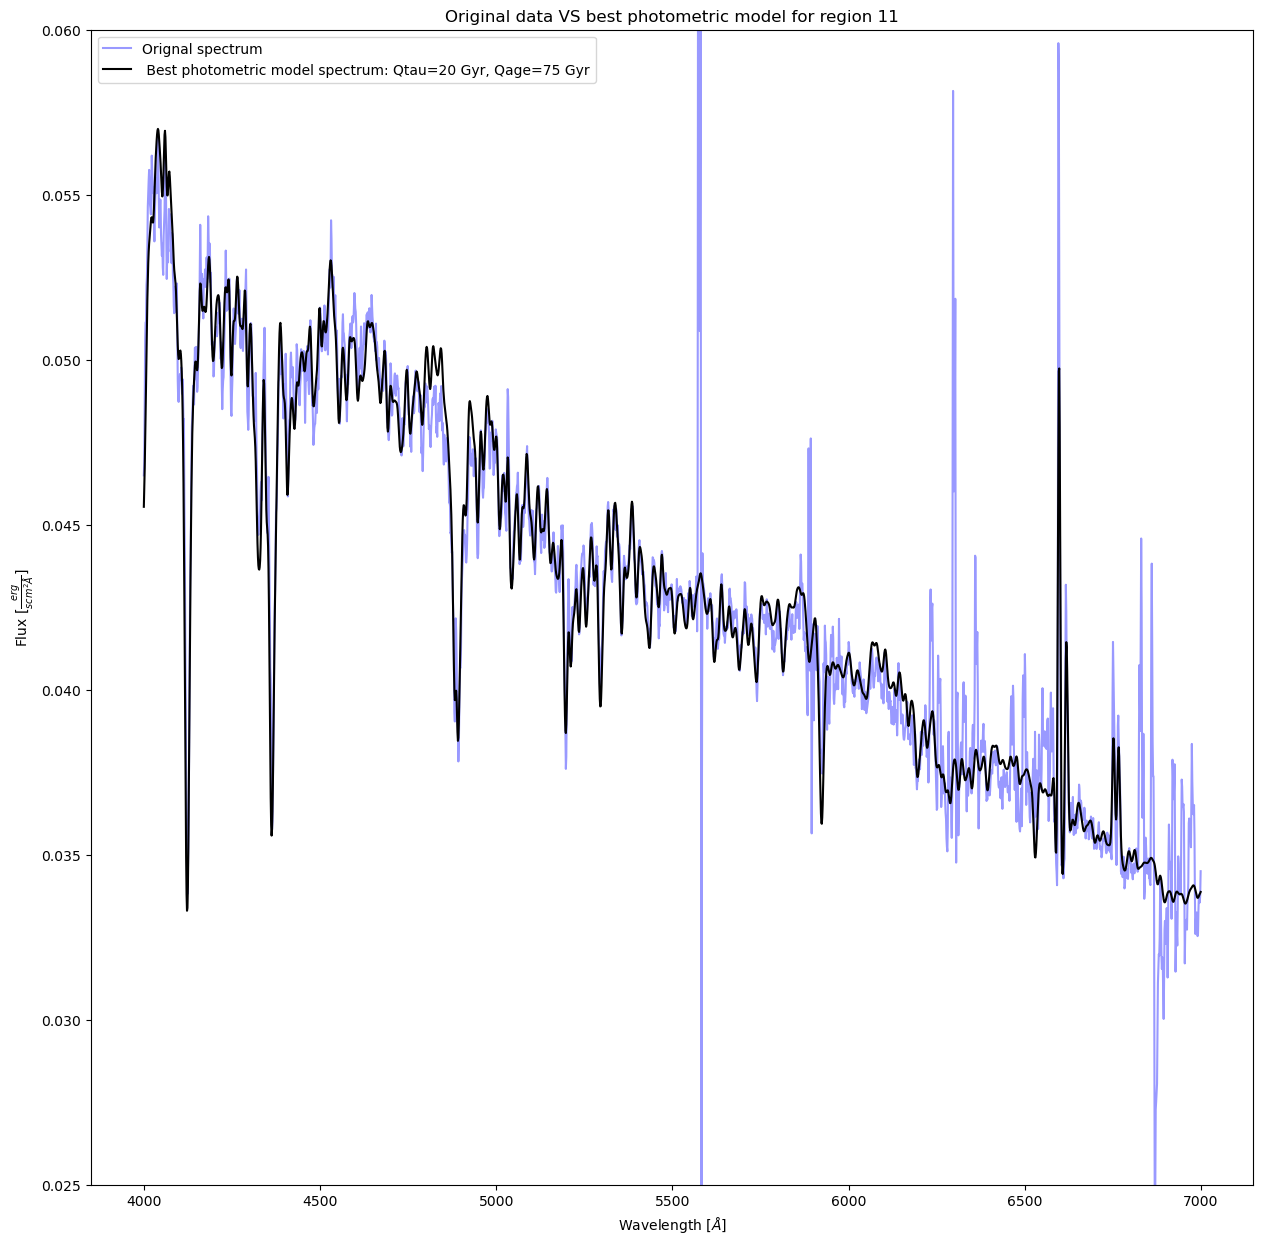

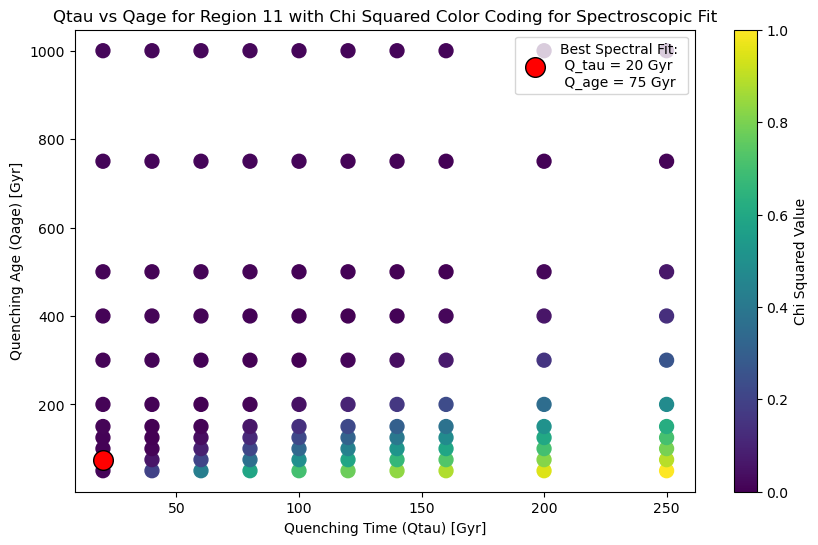

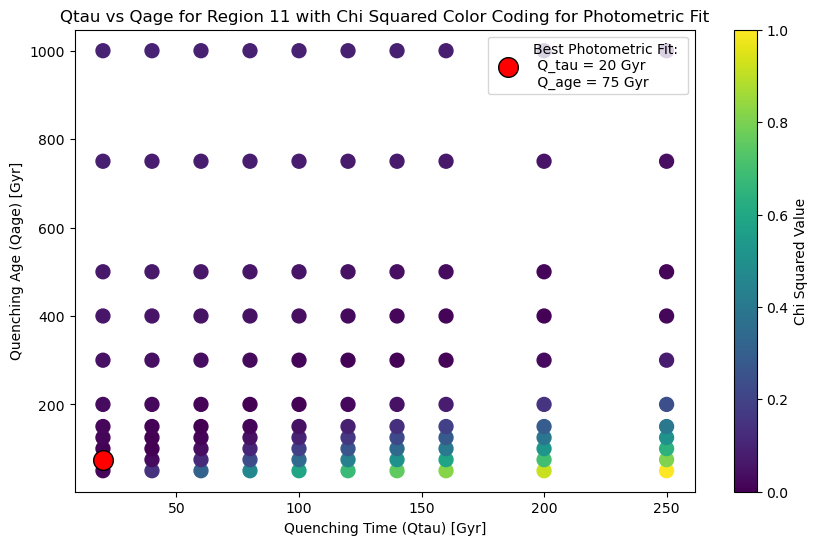


>>> Processing region 12 ...


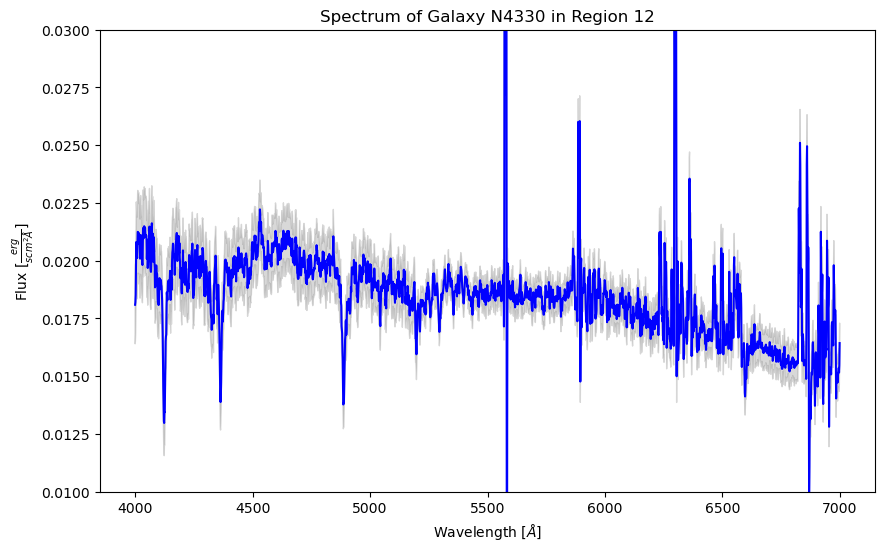

Regional photometry: 
  id f_FUV e_FUV  f_NUV e_NUV  f_U  ...  e_Z   f_IRAC1 e_IRAC1 f_IRAC4 e_IRAC4
--- ----- ------ ----- ----- ----- ... ------ ------- ------- ------- -------
 12  0.02 0.0018 0.057 0.003 0.374 ... 0.0814   0.942    0.05   0.298    0.08
Minumin of the chi squared reduced: 0.0008503130001547832, at index: 3
Minumin of the chi squared photometric reduced: 0.37837286474824106, at index: 28


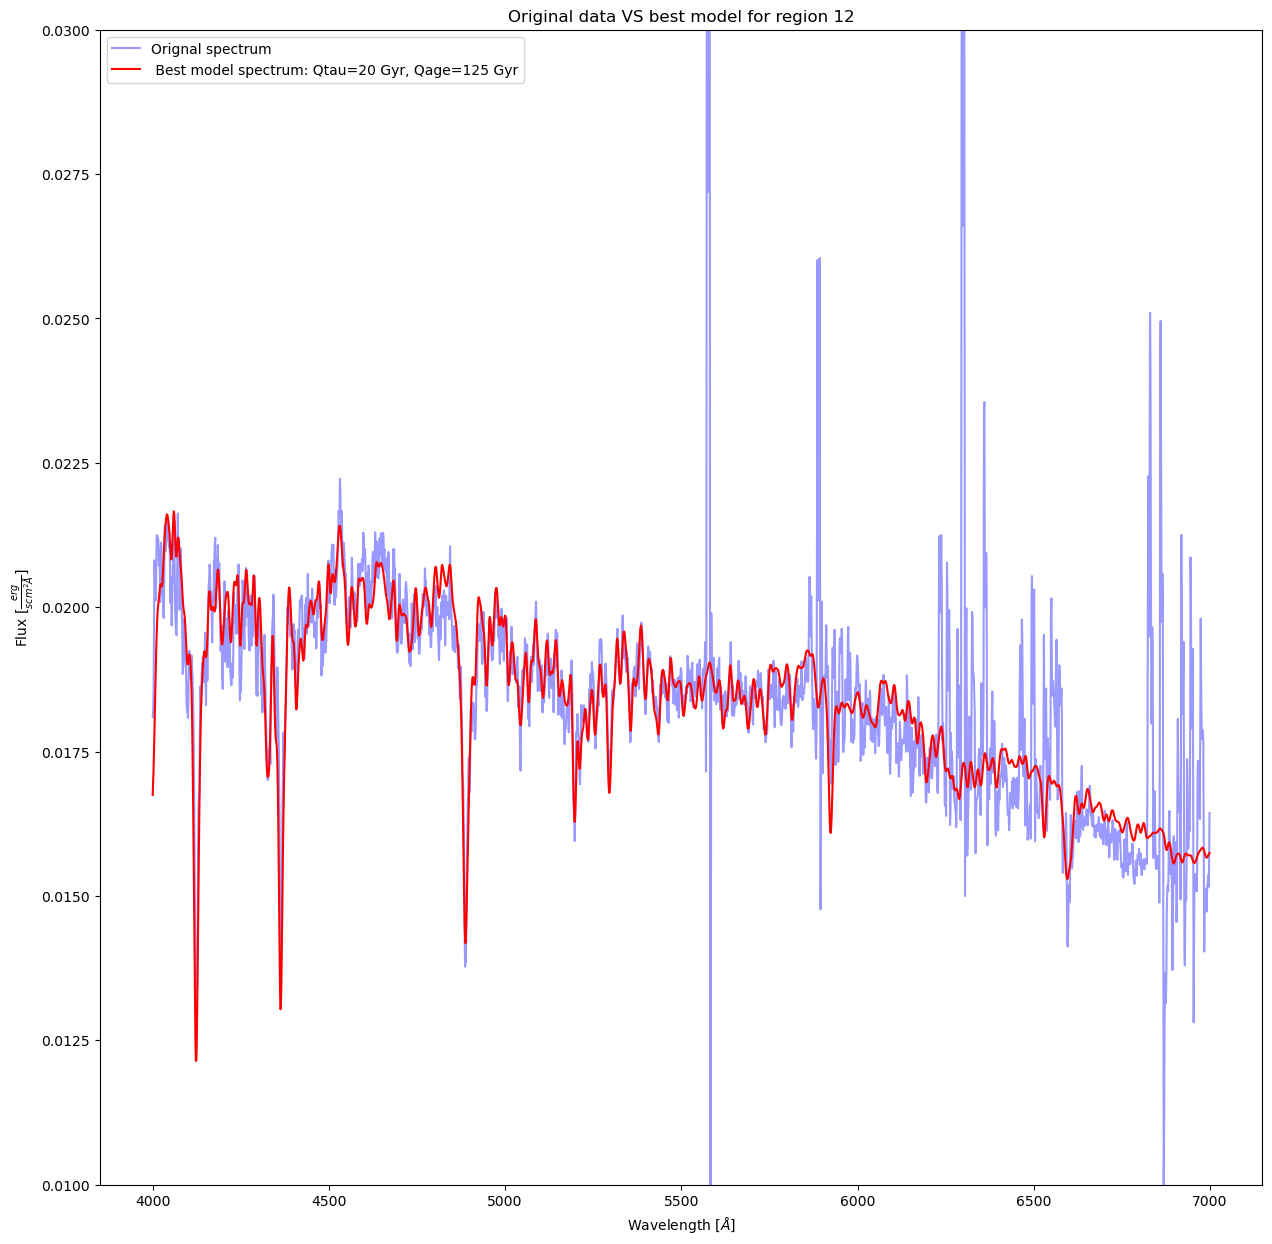

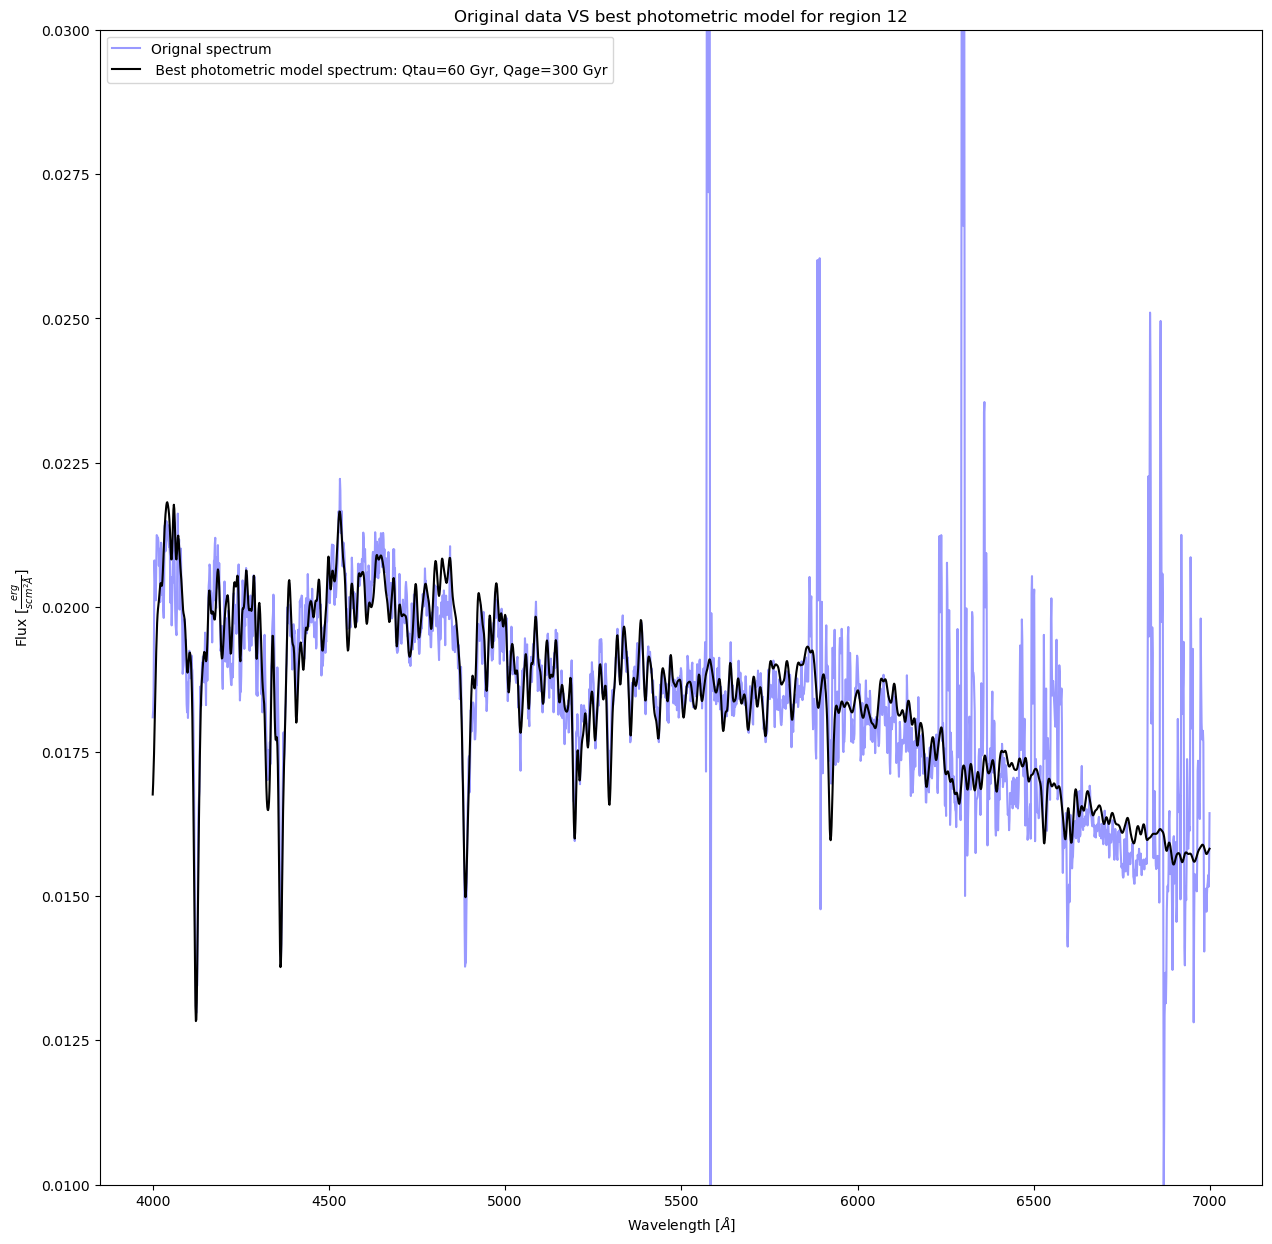

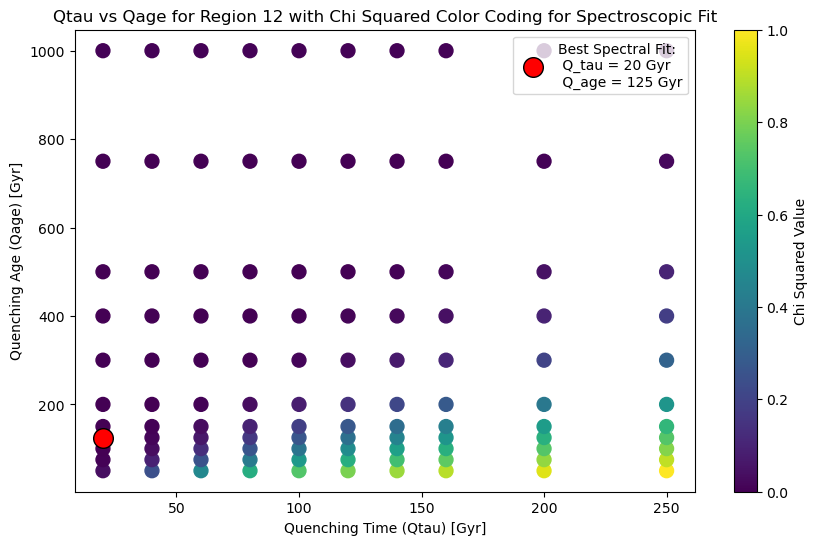

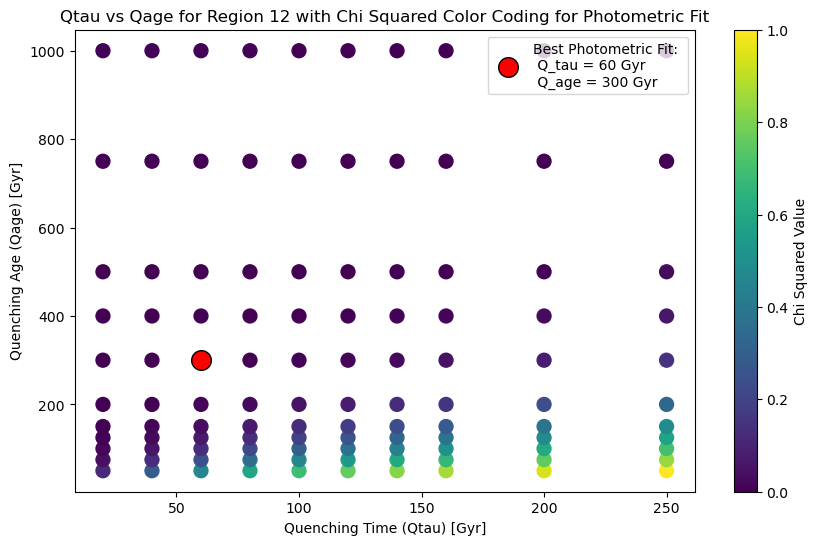


>>> Processing region 13 ...


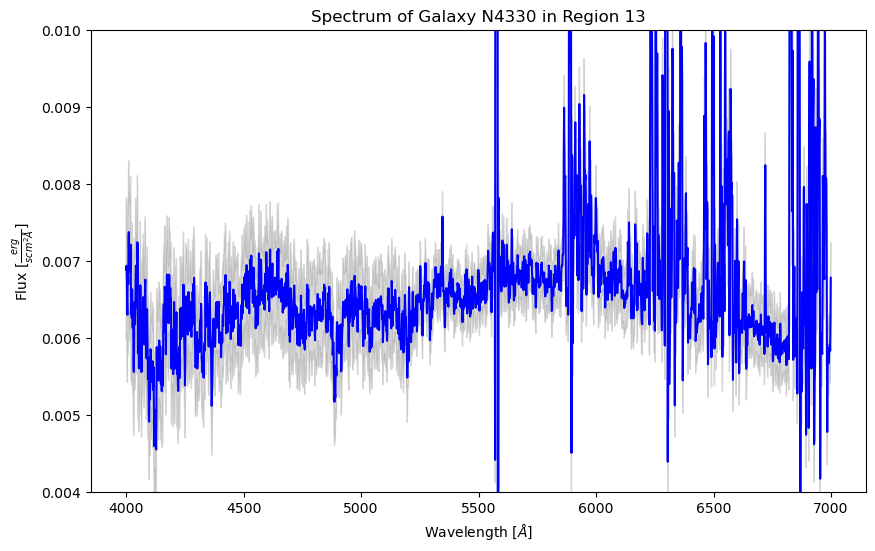

Regional photometry: 
  id f_FUV e_FUV f_NUV e_NUV  f_U  ...  e_Z  f_IRAC1 e_IRAC1 f_IRAC4 e_IRAC4
--- ----- ----- ----- ----- ----- ... ----- ------- ------- ------- -------
 13 0.007 0.002 0.032 0.004 0.323 ... 0.161   0.863   0.122   0.082   0.189
Minumin of the chi squared reduced: 0.002420202857669957, at index: 3
Minumin of the chi squared photometric reduced: 0.10108292052242467, at index: 18


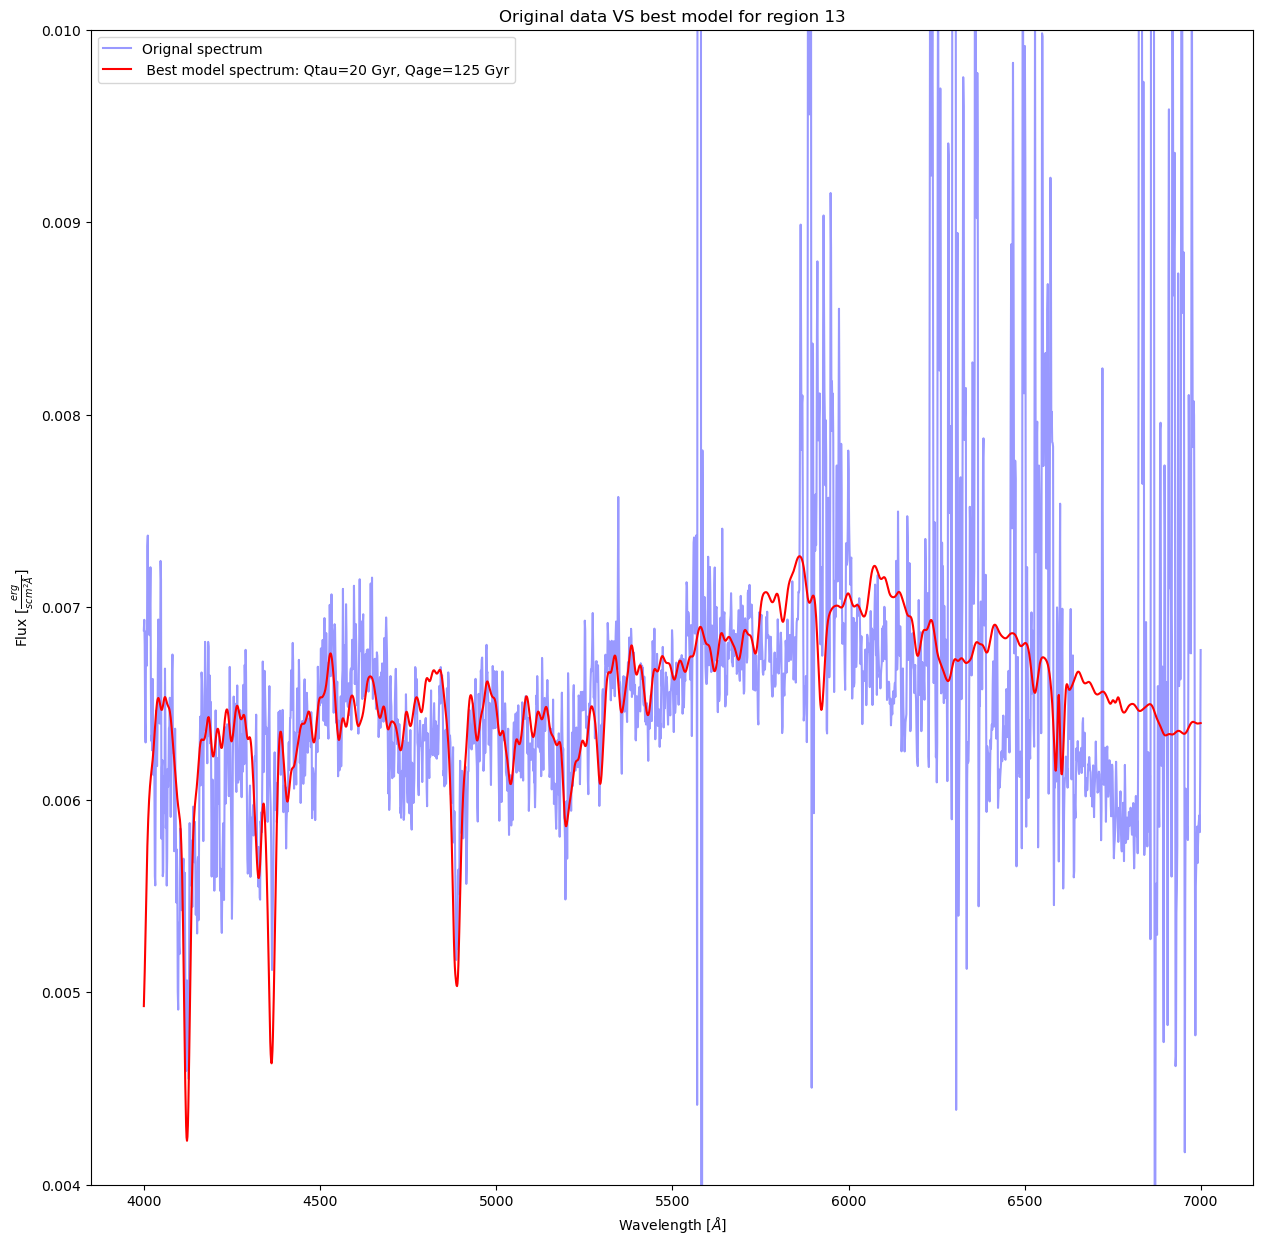

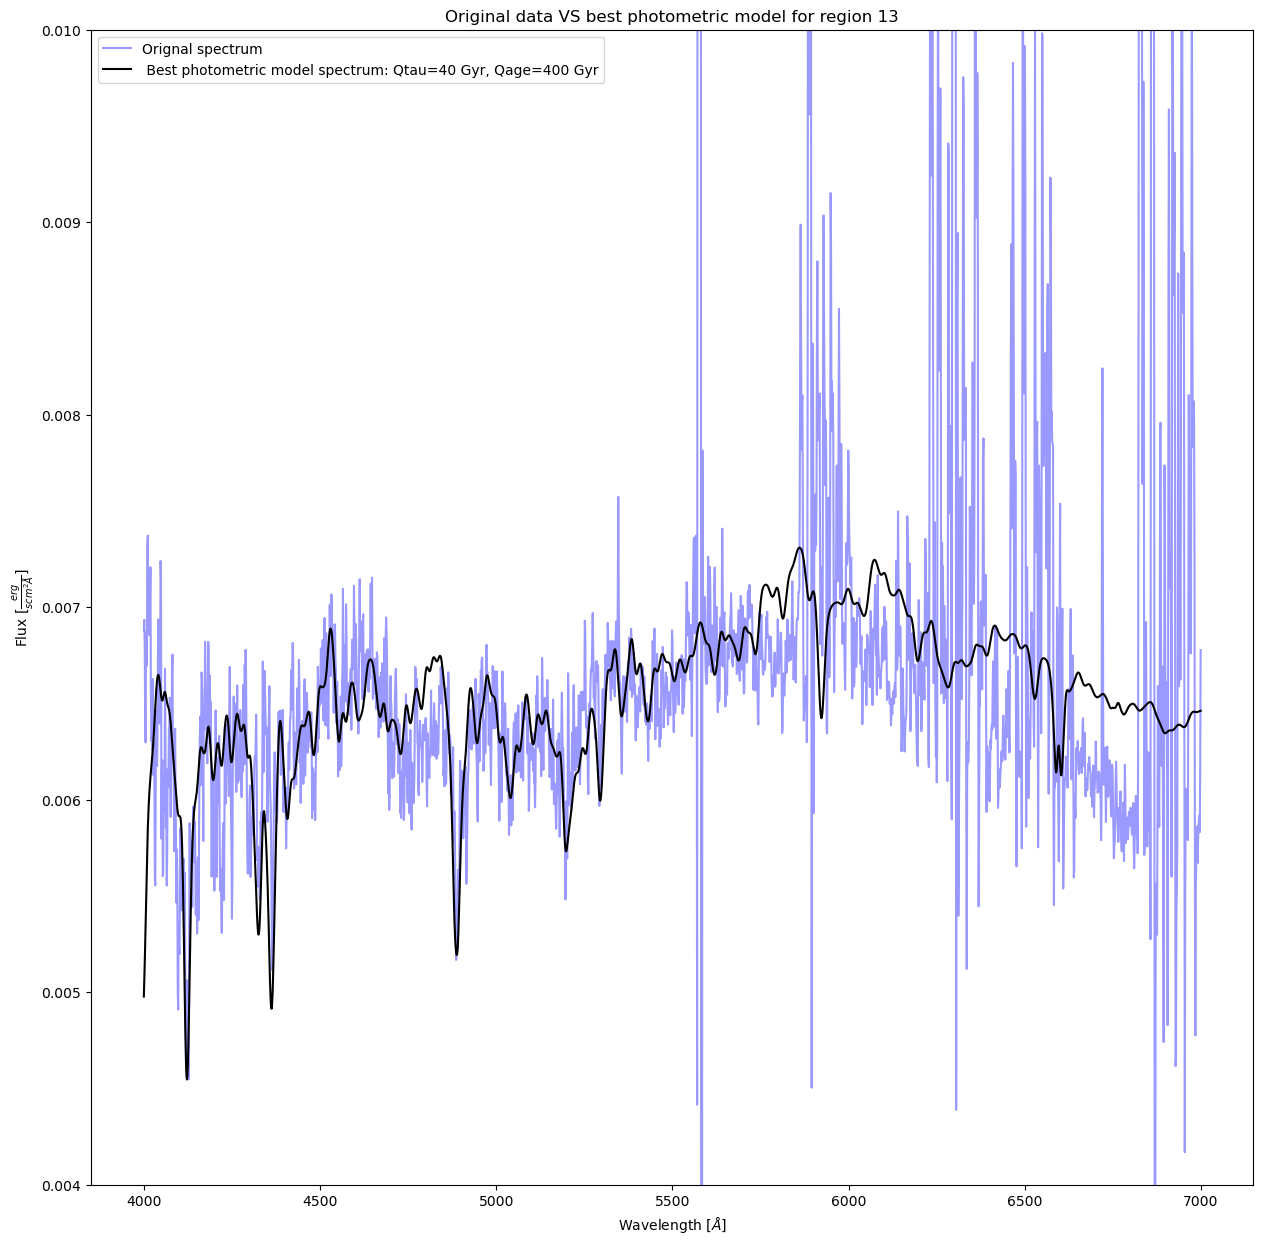

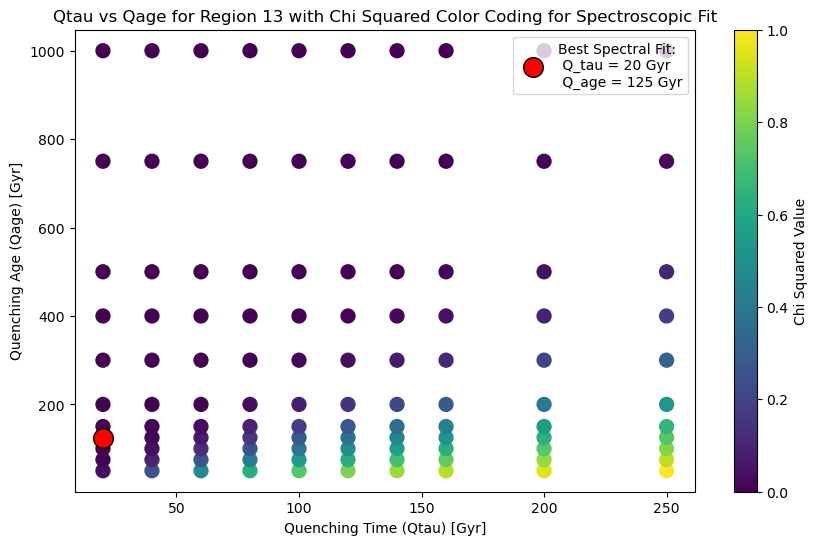

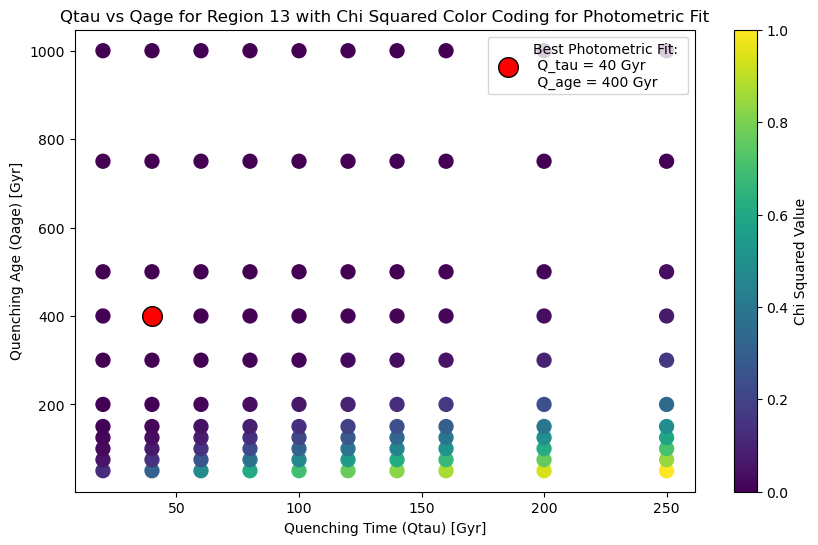


>>> Summary of Results:

Spectral fitting results:
Region 1: Quenching Time (Qtau) = 120 Gyr, Quenching Age (Qage) = 500 Gyr
Region 2: Quenching Time (Qtau) = 20 Gyr, Quenching Age (Qage) = 100 Gyr
Region 3: Quenching Time (Qtau) = 60 Gyr, Quenching Age (Qage) = 200 Gyr
Region 11: Quenching Time (Qtau) = 20 Gyr, Quenching Age (Qage) = 75 Gyr
Region 12: Quenching Time (Qtau) = 20 Gyr, Quenching Age (Qage) = 125 Gyr
Region 13: Quenching Time (Qtau) = 20 Gyr, Quenching Age (Qage) = 125 Gyr

Photometric fitting results:
Region 1: Quenching Time (Qtau) = 160 Gyr, Quenching Age (Qage) = 500 Gyr
Region 2: Quenching Time (Qtau) = 40 Gyr, Quenching Age (Qage) = 150 Gyr
Region 3: Quenching Time (Qtau) = 40 Gyr, Quenching Age (Qage) = 150 Gyr
Region 11: Quenching Time (Qtau) = 20 Gyr, Quenching Age (Qage) = 75 Gyr
Region 12: Quenching Time (Qtau) = 60 Gyr, Quenching Age (Qage) = 300 Gyr
Region 13: Quenching Time (Qtau) = 40 Gyr, Quenching Age (Qage) = 400 Gyr


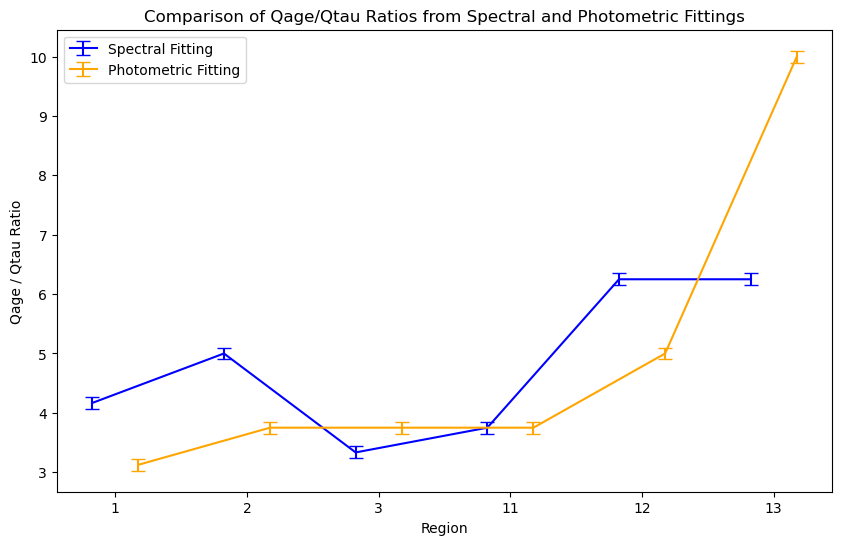

In [26]:
regions = [1, 2, 3, 11, 12, 13]
res_Qtau = []
res_Qage = []
res_Qtau_fot = []   
res_Qage_fot = []
ymax= [0.012, 0.045, 0.055, 0.06, 0.03, 0.01]
ymin= [0.005, 0.02, 0.025, 0.025, 0.01, 0.004]
photometry=Table.read(f"{THISDIR}\\Env_Qtime\\Phot_N4330.fits")
i=0

for j in regions:
    print(f"\n>>> Processing region {j} ...")
    #first we start by looking only at one region first we load the spectrum and then the model 
    spec = fits.open(f"{THISDIR}\\Env_Qtime\\Spec_N4330_region{j}.fits")
    specflx = spec[0].data
    specerr = spec[1].data
    specwav = spec[2].data
    err_upper = specflx + specerr
    err_lower = specflx - specerr

    plt.figure(figsize=(10,6))
    plt.plot(specwav,specflx, label='Spectrum', color='blue')
    plt.fill_between(specwav, err_lower, err_upper, color='gray', alpha=0.3, label='Error Range')
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Flux $[\frac{erg}{s cm^2 \AA}]$')
    plt.title(f'Spectrum of Galaxy N4330 in Region {j}')
    plt.ylim(ymin[i], ymax[i])
    plt.show()

    #Read model
    modhdu = fits.open(f"{THISDIR}\\Env_Qtime\\Models_N4330_region{j}.fits")
    Next = modhdu[0].header["NEXT"] #how many models are in this 
    modwave = modhdu[0].data
    chi_2=[]
    chi_2_fot=[]
    Qtau_array=[]
    Qage_array=[]
    Region_photometry = photometry[photometry['id'] == j] #takes the photometry for the specific region dividing it in values and errors
    usable_fot = np.array([Region_photometry['f_FUV'][0], Region_photometry['f_NUV'][0],
                           Region_photometry['f_U'][0], Region_photometry['f_G'][0],
                           Region_photometry['f_I'][0], Region_photometry['f_Z'][0],
                           Region_photometry['f_IRAC1'][0], Region_photometry['f_IRAC4'][0]])
    err_fot = np.array([Region_photometry['e_FUV'][0], Region_photometry['e_NUV'][0],
                        Region_photometry['e_U'][0], Region_photometry['e_G'][0],
                        Region_photometry['e_I'][0], Region_photometry['e_Z'][0],
                        Region_photometry['e_IRAC1'][0], Region_photometry['e_IRAC4'][0]])
    print(f"Regional photometry: \n {Region_photometry}")

    for ext in np.arange(1,Next+1): #first we calculate the chi squared for every model
        thisext = modhdu[ext]
        thishead = thisext.header
        modspec = thisext.data[0]
        modspec_adj= modspec*10**20
        photarr = np.array((thishead["MODFUV"],thishead["MODNUV"],\
        thishead["MODU"],thishead["MODG"],\
        thishead["MODI"],thishead["MODZ"], \
        thishead["MODIR1"],thishead["MODIR4"])) #then we confront the model photometry with the observed one
        res = specflx - modspec_adj
        res_fot = usable_fot - photarr
        chi_2.append(float(chi_squared_asymmetric(res, specerr))) #calculate chi squared for spectrum and photometry
        chi_2_fot.append(float(chi_squared_asymmetric(res_fot, err_fot)))
    
    index = np.argmin(chi_2) + 1
    print(f"Minumin of the chi squared reduced: {min(chi_2)/2400}, at index: {np.argmin(chi_2)}")
    index_fot = np.argmin(chi_2_fot) + 1
    print(f"Minumin of the chi squared photometric reduced: {min(chi_2_fot)/8}, at index: {np.argmin(chi_2_fot)}")

    for ext in np.arange(1,Next+1): #for the best model we plot the original data VS model 
        thisext = modhdu[ext]
        thishead = thisext.header
        modspec = thisext.data[0]
        modspec_adj= modspec*10**20
        Qtau = thishead["TRUNCTAU"]
        Qage = thishead["TRUNCAGE"]
        photarr = np.array((thishead["MODFUV"],thishead["MODNUV"],\
        thishead["MODU"],thishead["MODG"],\
        thishead["MODI"],thishead["MODZ"], \
        thishead["MODIR1"],thishead["MODIR4"])) #i suppose it's an array of fluxes
        Qtau_array.append(Qtau)
        Qage_array.append(Qage)
        if ext == index : #plot for the best model 
            res_Qtau.append(Qtau)
            res_Qage.append(Qage)
            plt.figure(figsize=(15,15))
            plt.plot(specwav, specflx, label='Orignal spectrum', color='blue', alpha=0.4)
            plt.plot(specwav, modspec_adj, label=f' Best model spectrum: Qtau={Qtau} Gyr, Qage={Qage} Gyr', color='red')
            plt.xlabel(r'Wavelength [$\AA$]')
            plt.ylabel(r'Flux $[\frac{erg}{s cm^2 \AA}]$')
            plt.title(f'Original data VS best model for region {j}')
            plt.legend()
            plt.ylim(ymin[i], ymax[i])
            plt.show()

        if ext == index_fot : #plot for the best photometric model 
            res_Qtau_fot.append(Qtau)
            res_Qage_fot.append(Qage)
            plt.figure(figsize=(15,15))
            plt.plot(specwav, specflx, label='Orignal spectrum', color='blue', alpha=0.4)
            plt.plot(specwav, modspec_adj, label=f' Best photometric model spectrum: Qtau={Qtau} Gyr, Qage={Qage} Gyr', color='black')
            plt.xlabel(r'Wavelength [$\AA$]')
            plt.ylabel(r'Flux $[\frac{erg}{s cm^2 \AA}]$')
            plt.title(f'Original data VS best photometric model for region {j}')
            plt.legend()
            plt.ylim(ymin[i], ymax[i])
            plt.show()
    
    #now fot this region we can plot all the couples of Qtau and Qage (arrays res_Qtau and res_Qage) in a grid with color the chi squared value (using the array chi_2)
    plt.figure(figsize=(10,6))
    plt.scatter(Qtau_array, Qage_array, c=chi_2, cmap='viridis', s=100)
    plt.scatter(res_Qtau[-1], res_Qage[-1], color='red', label=f'Best Spectral Fit: \n Q_tau = {res_Qtau[-1]} Gyr\n Q_age = {res_Qage[-1]} Gyr', s=200, edgecolors='black')
    plt.colorbar(label='Chi Squared Value')
    plt.xlabel('Quenching Time (Qtau) [Gyr]')
    plt.ylabel('Quenching Age (Qage) [Gyr]')
    plt.legend()
    plt.title(f'Qtau vs Qage for Region {j} with Chi Squared Color Coding for Spectroscopic Fit')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.scatter(Qtau_array, Qage_array, c=chi_2_fot, cmap='viridis', s=100)
    plt.scatter(res_Qtau_fot[-1], res_Qage_fot[-1], color='red', label=f'Best Photometric Fit: \n Q_tau = {res_Qtau_fot[-1]} Gyr\n Q_age = {res_Qage_fot[-1]} Gyr', s=200, edgecolors='black')
    plt.colorbar(label='Chi Squared Value')
    plt.xlabel('Quenching Time (Qtau) [Gyr]')
    plt.ylabel('Quenching Age (Qage) [Gyr]')
    plt.legend()
    plt.title(f'Qtau vs Qage for Region {j} with Chi Squared Color Coding for Photometric Fit')
    plt.show()
    i=i+1

print("\n>>> Summary of Results:")
print("\nSpectral fitting results:")
for i in range(len(res_Qtau)):
    print(f"Region {regions[i]}: Quenching Time (Qtau) = {res_Qtau[i]} Gyr, Quenching Age (Qage) = {res_Qage[i]} Gyr")
print("\nPhotometric fitting results:")
for i in range(len(res_Qtau)):
    print(f"Region {regions[i]}: Quenching Time (Qtau) = {res_Qtau_fot[i]} Gyr, Quenching Age (Qage) = {res_Qage_fot[i]} Gyr")


#now we plot the ratio between Qage and Qtau for both spectral and photometric fittings
plt.figure(figsize=(10,6))
ratios_spec = [res_Qage[i]/res_Qtau[i] for i in range(len(res_Qtau))]
ratios_fot = [res_Qage_fot[i]/res_Qtau_fot[i] for i in range(len(res_Qtau_fot))]
width = 0.35
x = np.arange(len(regions))
plt.errorbar(x - width/2, ratios_spec, yerr=0.1, fmt='', label='Spectral Fitting', color='blue', capsize=5)
plt.errorbar(x + width/2, ratios_fot, yerr=0.1 , fmt='', label='Photometric Fitting', color='orange', capsize=5)
plt.xlabel('Region')
plt.ylabel('Qage / Qtau Ratio')
plt.title('Comparison of Qage/Qtau Ratios from Spectral and Photometric Fittings')
plt.xticks(x, regions)
plt.legend()
plt.show()  


In [9]:
photometry

<Table length=6>
  id   f_FUV   e_FUV   f_NUV   e_NUV  ... f_IRAC1 e_IRAC1 f_IRAC4 e_IRAC4
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1    0.07  0.0025   0.111   0.005 ...   1.329    0.11   0.341   0.197
    2   0.107   0.005   0.171   0.008 ...   1.477   0.049   0.598    0.08
    3  0.1229   0.006   0.188   0.009 ...   2.452   0.052   3.079   0.085
   11   0.145    0.07   0.219    0.01 ...   2.068   0.052   3.326   0.084
   12    0.02  0.0018   0.057   0.003 ...   0.942    0.05   0.298    0.08
   13   0.007   0.002   0.032   0.004 ...   0.863   0.122   0.082   0.189